# Comparing Traditional Time-Series Forecasting Methods with Time-Series Transformers

## Introduction
In the recent year, there has been a significant shift in the field of time-series forecasting. some may said the ImageNet moment for time-sereis. Major tech companies such as Amazon, Google, and Salesforce, among others, have introduced open-source transformers specifically designed for time-series forecasting. These models claim to outperform traditional forecasting methods in accuracy and efficiency. In this notebook, we will explore and compare traditional time-series forecasting methods like ARIMA, Exponential Smoothing, and more with these new time-series transformers, specifically Chronos and Moirai-MoE. Our focus will be on tackling a well-known problem in time-series forecasting and data science: predicting future energy consumption and pricing. Specifically, we will apply these models to forecast the actual price of energy in Spain.

## Problem Definition and Importance

Forecasting the price of electricity is a crucial task for energy companies, grid operators, and consumers. Electricity prices fluctuate due to various factors, including supply and demand, weather conditions, and market regulations. Accurate price predictions can help companies make informed decisions about energy procurement, production scheduling, and cost management, ultimately leading to increased efficiency and cost savings.

Moreover, forecasting electricity prices is almost the same as predicting actual electricity consumption. By accurately predicting usage patterns, we can optimize energy distribution, reduce waste, and promote greener energy consumption. With better forecasting, companies and grid operators can allocate energy more effectively, improve the utilization of renewable energy sources, and enhance energy storage strategies. This can lead to reduced reliance on fossil fuels, lower carbon emissions, and a more sustainable energy ecosystem.

## Dataset

The dataset used in this study comprises weather and energy data from Spain, collected between 2014 and 2019. It includes various features such as temperature, wind speed, energy generation, and consumption. Our target variable is the actual price of energy, which we aim to forecast using different methodologies.

### Exploratory Data Analysis (EDA)

During the EDA phase, we will conduct data preprocessing and feature extraction specifically tailored for time-series data. This involves handling missing values, identifying and addressing non-stationary series, and extracting key features such as seasonal patterns, trends, and autocorrelation (ACF). These steps are crucial for understanding the underlying structure of the data and preparing it for more effective modeling.


We will apply each forecasting method to the dataset and evaluate their performance using metrics such as RMSE and MAPE.

## Traditional Methods
- **ARIMA (AutoRegressive Integrated Moving Average)**
- **Prophet**
- **AutoARIMAProphet**

## Deep Learning Models

- **LSTM**  
  LSTM networks capture long-term dependencies and can learn sequential patterns over extended periods.
  
- **LSTM + CNN**  
  This hybrid model uses a CNN to extract local features and an LSTM to model the overall temporal dynamics, offering a balance between capturing short-term fluctuations and long-term trends.

## Time-Series Transformers

1. **Chronos**
2. **Moirai-MoE**

The transformers used in this comparison are pre-trained on other datasets and fine-tuned for our specific task. These models will be evaluated in a zero-shot setting, where they are directly applied to our dataset without additional training.

## Results and Comparison

- **Performance Metrics**: We will calculate RMSE to quantify the accuracy of each method.
- **Visual Comparisons**: Plots will be generated to visually compare the forecasts from traditional methods and transformers.

## Conclusion

The final section will discuss the strengths and weaknesses of each approach, highlighting the conditions under which each method performs best.


In [97]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import math
from sklearn.preprocessing import LabelEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from pmdarima import preprocessing as ppc
from pmdarima import pipeline
from pmdarima import model_selection
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans

import pickle

from sklearn.manifold import TSNE

from prophet import Prophet
from statsforecast.adapters.prophet import AutoARIMAProphet

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, LSTM, Conv1D


## Dataset Overview

The dataset used in this study spans four years, from 2014 to 2019, and includes various aspects of electrical consumption, generation, pricing, and weather data for Spain. This comprehensive dataset was compiled from several sources to provide a detailed view of the energy market and its influencing factors during this period.

### Data Sources
- **Electrical Consumption and Generation**: The data was sourced from ENTSOE, a public portal that provides data from Transmission Service Operators (TSOs). This includes detailed records of energy consumption and various methods of energy generation across Spain.
- **Settlement Prices**: Pricing data was retrieved from the Spanish TSO, Red Eléctrica de España. This provides the actual settlement prices for energy, which is crucial for understanding the market dynamics.
- **Weather Data**: Weather information was obtained from the Open Weather API and covers the five largest cities in Spain. This data includes various meteorological parameters, which are essential 


In [2]:
# read weather datasets, turn the dt_iso column into a datetime object
df_weather = pd.read_csv(
    'datasets/weather_features.csv'
)
# read energy dataset, turn the time column into a datetime object
df_energy = pd.read_csv(
    'datasets/energy_dataset.csv'
)
df_energy['time'] = pd.to_datetime(df_energy['time'],utc=True)
# Set the 'time' column as the index
df_energy.set_index('time', inplace=True)

df_weather['dt_iso'] = pd.to_datetime(df_weather['dt_iso'],utc=True)
df_weather['time'] = df_weather['dt_iso']
df_weather['time'] = pd.to_datetime(df_weather['time'],utc=True)
df_weather.index = df_weather['time']
df_weather = df_weather.drop(['dt_iso'],axis=1)
# Filter out rows from 2014 for the energy dataset
df_energy = df_energy[df_energy.index.year > 2014]

# Filter out rows from 2014 for the weather dataset
df_weather = df_weather[df_weather.index.year > 2014]


### Exploratory Data Analysis (EDA)

In this section, we will begin by cleaning and preprocessing the energy dataset. First, we will examine the dataset using the `describe()` method to obtain an overview of the statistical properties of each column. Here are some of the columns we will inspect:

- **Generation Data**: This includes various energy generation methods such as biomass, fossil fuels (coal, gas, oil), hydro (pumped storage, run-of-river, and water reservoir), nuclear, wind, solar, and waste. These columns reflect the energy generation by different sources across Spain.
- **Forecast Data**: This includes the forecast values for solar, wind, and total load on a day-ahead basis.
- **Actual Energy Load and Prices**: These include the total load , as well as the day-ahead energy prices, which provide insights into the real-time energy market dynamics that we will want to predict.


In [3]:

# we will start analyzing the energy dataset
df_energy.describe()

generation biomass  generation fossil brown coal/lignite  \
count        35044.000000                          35045.000000   
mean           383.511728                            448.062605   
std             85.354487                            354.573079   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation fossil coal-derived gas  generation fossil gas  \
count                             35045.0           35045.000000   
mean                                  0.0            5622.759709   
std                                   0.0            2201.857963   
min                                   0.0               0.000000   
25%                                   0.0            4126.000000   
50%                                   0.0            4969.000000   
75%                                   0.0            6429.000000   
max                                   0.0           20034.000000   

       generation fossil hard coal  generation fossil oil  \
count                 35045.000000           35044.000000   
mean                   4256.049622             298.323679   
std                    1961.626679              52.516373   
min                       0.000000               0.000000   
25%                    2527.000000             263.000000   
50%                    4474.000000             300.000000   
75%                    5839.000000             330.000000   
max                    8359.000000             449.000000   

       generation fossil oil shale  generation fossil peat  \
count                      35045.0                 35045.0   
mean                           0.0                     0.0   
std                            0.0                     0.0   
min                            0.0                     0.0   
25%                            0.0                     0.0   
50%                            0.0                     0.0   
75%                            0.0                     0.0   
max                            0.0                     0.0   

       generation geothermal  generation hydro pumped storage aggregated  \
count                35045.0                                         0.0   
mean                     0.0                                         NaN   
std                      0.0                                         NaN   
min                      0.0                                         NaN   
25%                      0.0                                         NaN   
50%                      0.0                                         NaN   
75%                      0.0                                         NaN   
max                      0.0                                         NaN   

       generation hydro pumped storage consumption  \
count                                 35044.000000   
mean                                    475.566288   
std                                     792.415217   
min                                       0.000000   
25%                                       0.000000   
50%                                      68.000000   
75%                                     616.000000   
max                                    4523.000000   

       generation hydro run-of-river and poundage  \
count                                35044.000000   
mean                                   972.113857   
std                                    400.783033   
min                                      0.000000   
25%                                    637.000000   
50%                                    906.000000   
75%                                   1250.000000   
max                                   2000.000000   

       generation hydro water r

We can see a lot of things from the `describe()` function about the dataset. First, we can see that there are some columns with only NaN values in them. This suggests that these columns might not contain any useful information for our analysis. We will calculate the percentage of NaN values in these columns to identify those that have a significant proportion of missing data. This will help us determine if there are other columns with a considerable amount of NaN values that might need to be dropped or handled with imputation. The goal is to clean the dataset and retain only the most useful features for building our models.


In [4]:
# Calculate the number of missing values for each column
missing_counts = df_energy.isna().sum()

# Calculate the percentage of missing values for each column
missing_percentages = (df_energy.isna().mean() * 100).sort_values(ascending=False)

missing_percentages.head(5)


generation hydro pumped storage aggregated    100.000000
forecast wind offshore eday ahead             100.000000
total load actual                               0.102672
generation waste                                0.054188
generation marine                               0.054188
dtype: float64

As observed, there are two columns that contain only NaN values(generation hydro pumped storage aggregated,forecast wind offshore eday ahead)), while the remaining columns have a relatively low percentage of missing values. We will keep the relatively low percentage columns for now and drop the NaN columns.


In [5]:
df_energy = df_energy.drop(['forecast wind offshore eday ahead', 'generation hydro pumped storage aggregated'],axis=1)


Eariler we saw on the df_energy.describe() that there are some colums with only 0 values, so they dont give us any information. so we will drop them also.

In [6]:

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale','generation fossil peat','generation marine','generation wind offshore','generation geothermal'],axis=1)

### Dropping Forecast Columns

In this step, we drop all columns related to forecast data. These columns contain predicted values that are not useful for our analysis, as our goal is to forecast the energy prices ourselves. Keeping them in the dataset could introduce unnecessary biases or inaccuracies. Therefore, we remove any columns whose names contain the word "forecast" to ensure we only work with the relevant data for our own forecasting task.


In [7]:
to_drop = [col for col in df_energy.columns if 'forecast' in col]
print(to_drop)
df_energy = df_energy.drop(to_drop, axis=1)

['forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast']


In this step, we calculate the number of missing (NaN) values for each column in the dataset. We then plot a bar chart to visualize the count of missing values for columns that have missing data.

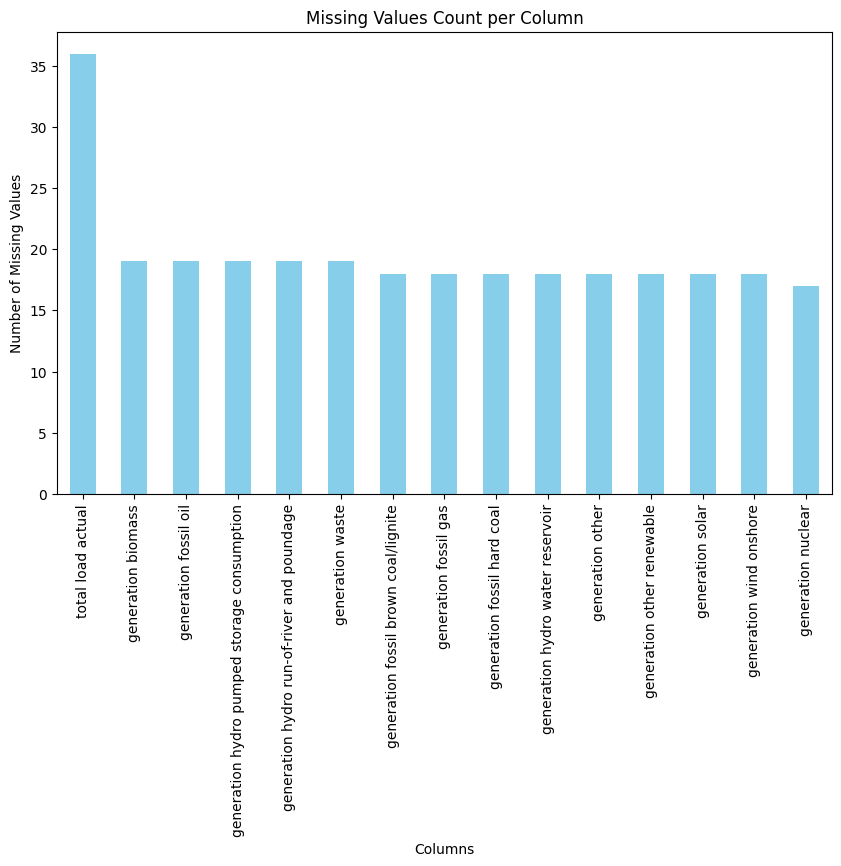

In [8]:
missing_count = df_energy.isna().sum()

# Plotting the missing values count
plt.figure(figsize=(10, 6))
missing_count[missing_count > 0].sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Missing Values Count per Column")
plt.ylabel("Number of Missing Values")
plt.xlabel("Columns")
plt.xticks(rotation=90)
plt.show()


As we can see, comparing to a 35045 samples, the column with the most nan values have only 34 NaN, so it not a critical error.



In this step, we create a plot of the 'Total Load Actual' against time to visualize the data over a specific time range. By zooming in on a particular period (from '2015-01-01' to '2015-02-02'), we can better observe the trends, patterns, and any potential gaps or anomalies in the data. This visualization will help us understand the behavior of the 'Total Load Actual' variable, which is crucial for deciding how to handle missing values and perform imputation. The goal is to examine the time-series data to inform our approach to filling any gaps, whether through interpolation or other methods.


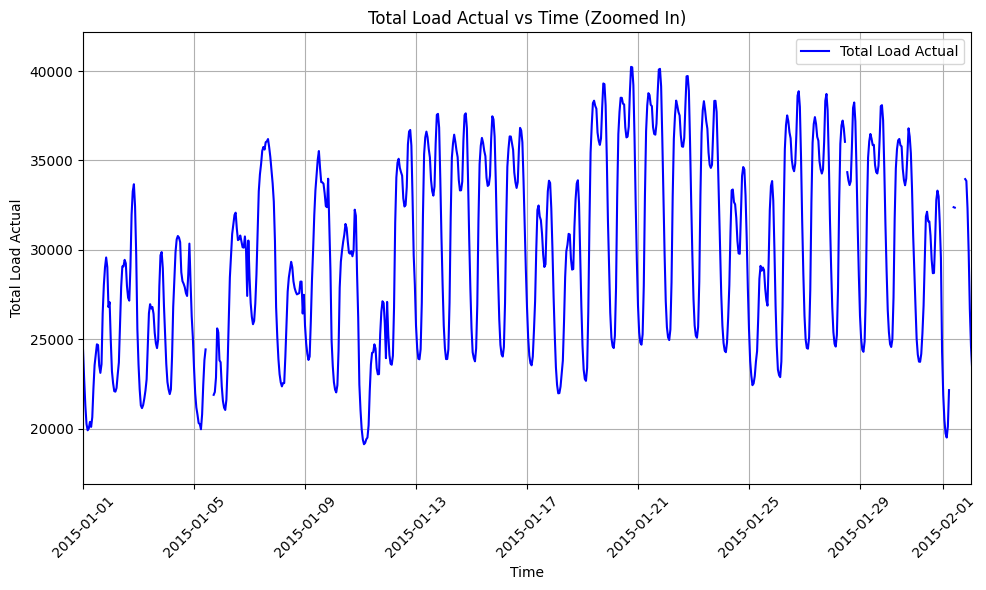

In [9]:

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_energy.index, df_energy['total load actual'], label='Total Load Actual', color='blue')

# Set x-axis limit to zoom into specific time range (e.g., from '2015-01-01' to '2015-02-02')
plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-02-02'))

plt.title('Total Load Actual vs Time (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Total Load Actual')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


We can see that in the beginning of 2015-01-05 there is a missing value.
Time series data relies on the order and continuity of time-based observations. If you remove rows with missing data, you can break this continuity, leading to gaps in your time series, also , in more techinal approach, Many time series models (e.g., ARIMA, LSTM) require the data to be continuous and use previous observations to make predictions. Dropping rows can disturb this temporal relationship, leading to poor model performance.
so we will need to fill the missing values, as we can see in the plot we just plotted that the data of Load Actual is linear. so a good approach would be to use linear interplation in here.
2 more possible approachs that are common in time-series data is fill forward that will replaces NaN with the immediat next value, and backword fill thah replaces NaN with the immediate previous value.
The reason I am choosing linear interplation its becuase, as we can see there is a somekind of gap between night and day, which linear interploate will solve but the other methods can make a bigger gap and less smoother.

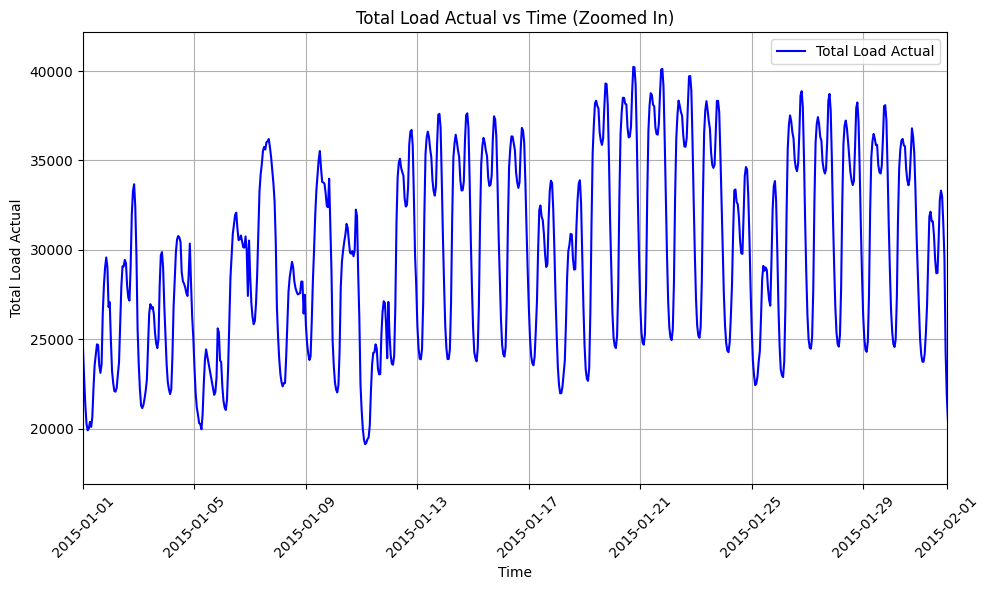

In [10]:

df_energy['total load actual'] = df_energy['total load actual'].interpolate(method='linear')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_energy.index, df_energy['total load actual'], label='Total Load Actual', color='blue')

# Set x-axis limit to zoom into specific time range (e.g., from '2015-01-01' to '2015-02-01')
plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-02-01'))

plt.title('Total Load Actual vs Time (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Total Load Actual')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

we can see that missing value is filled and the line looks "natural".

Now we will go all over our features and we would try to figure out how should we fill the missing values.

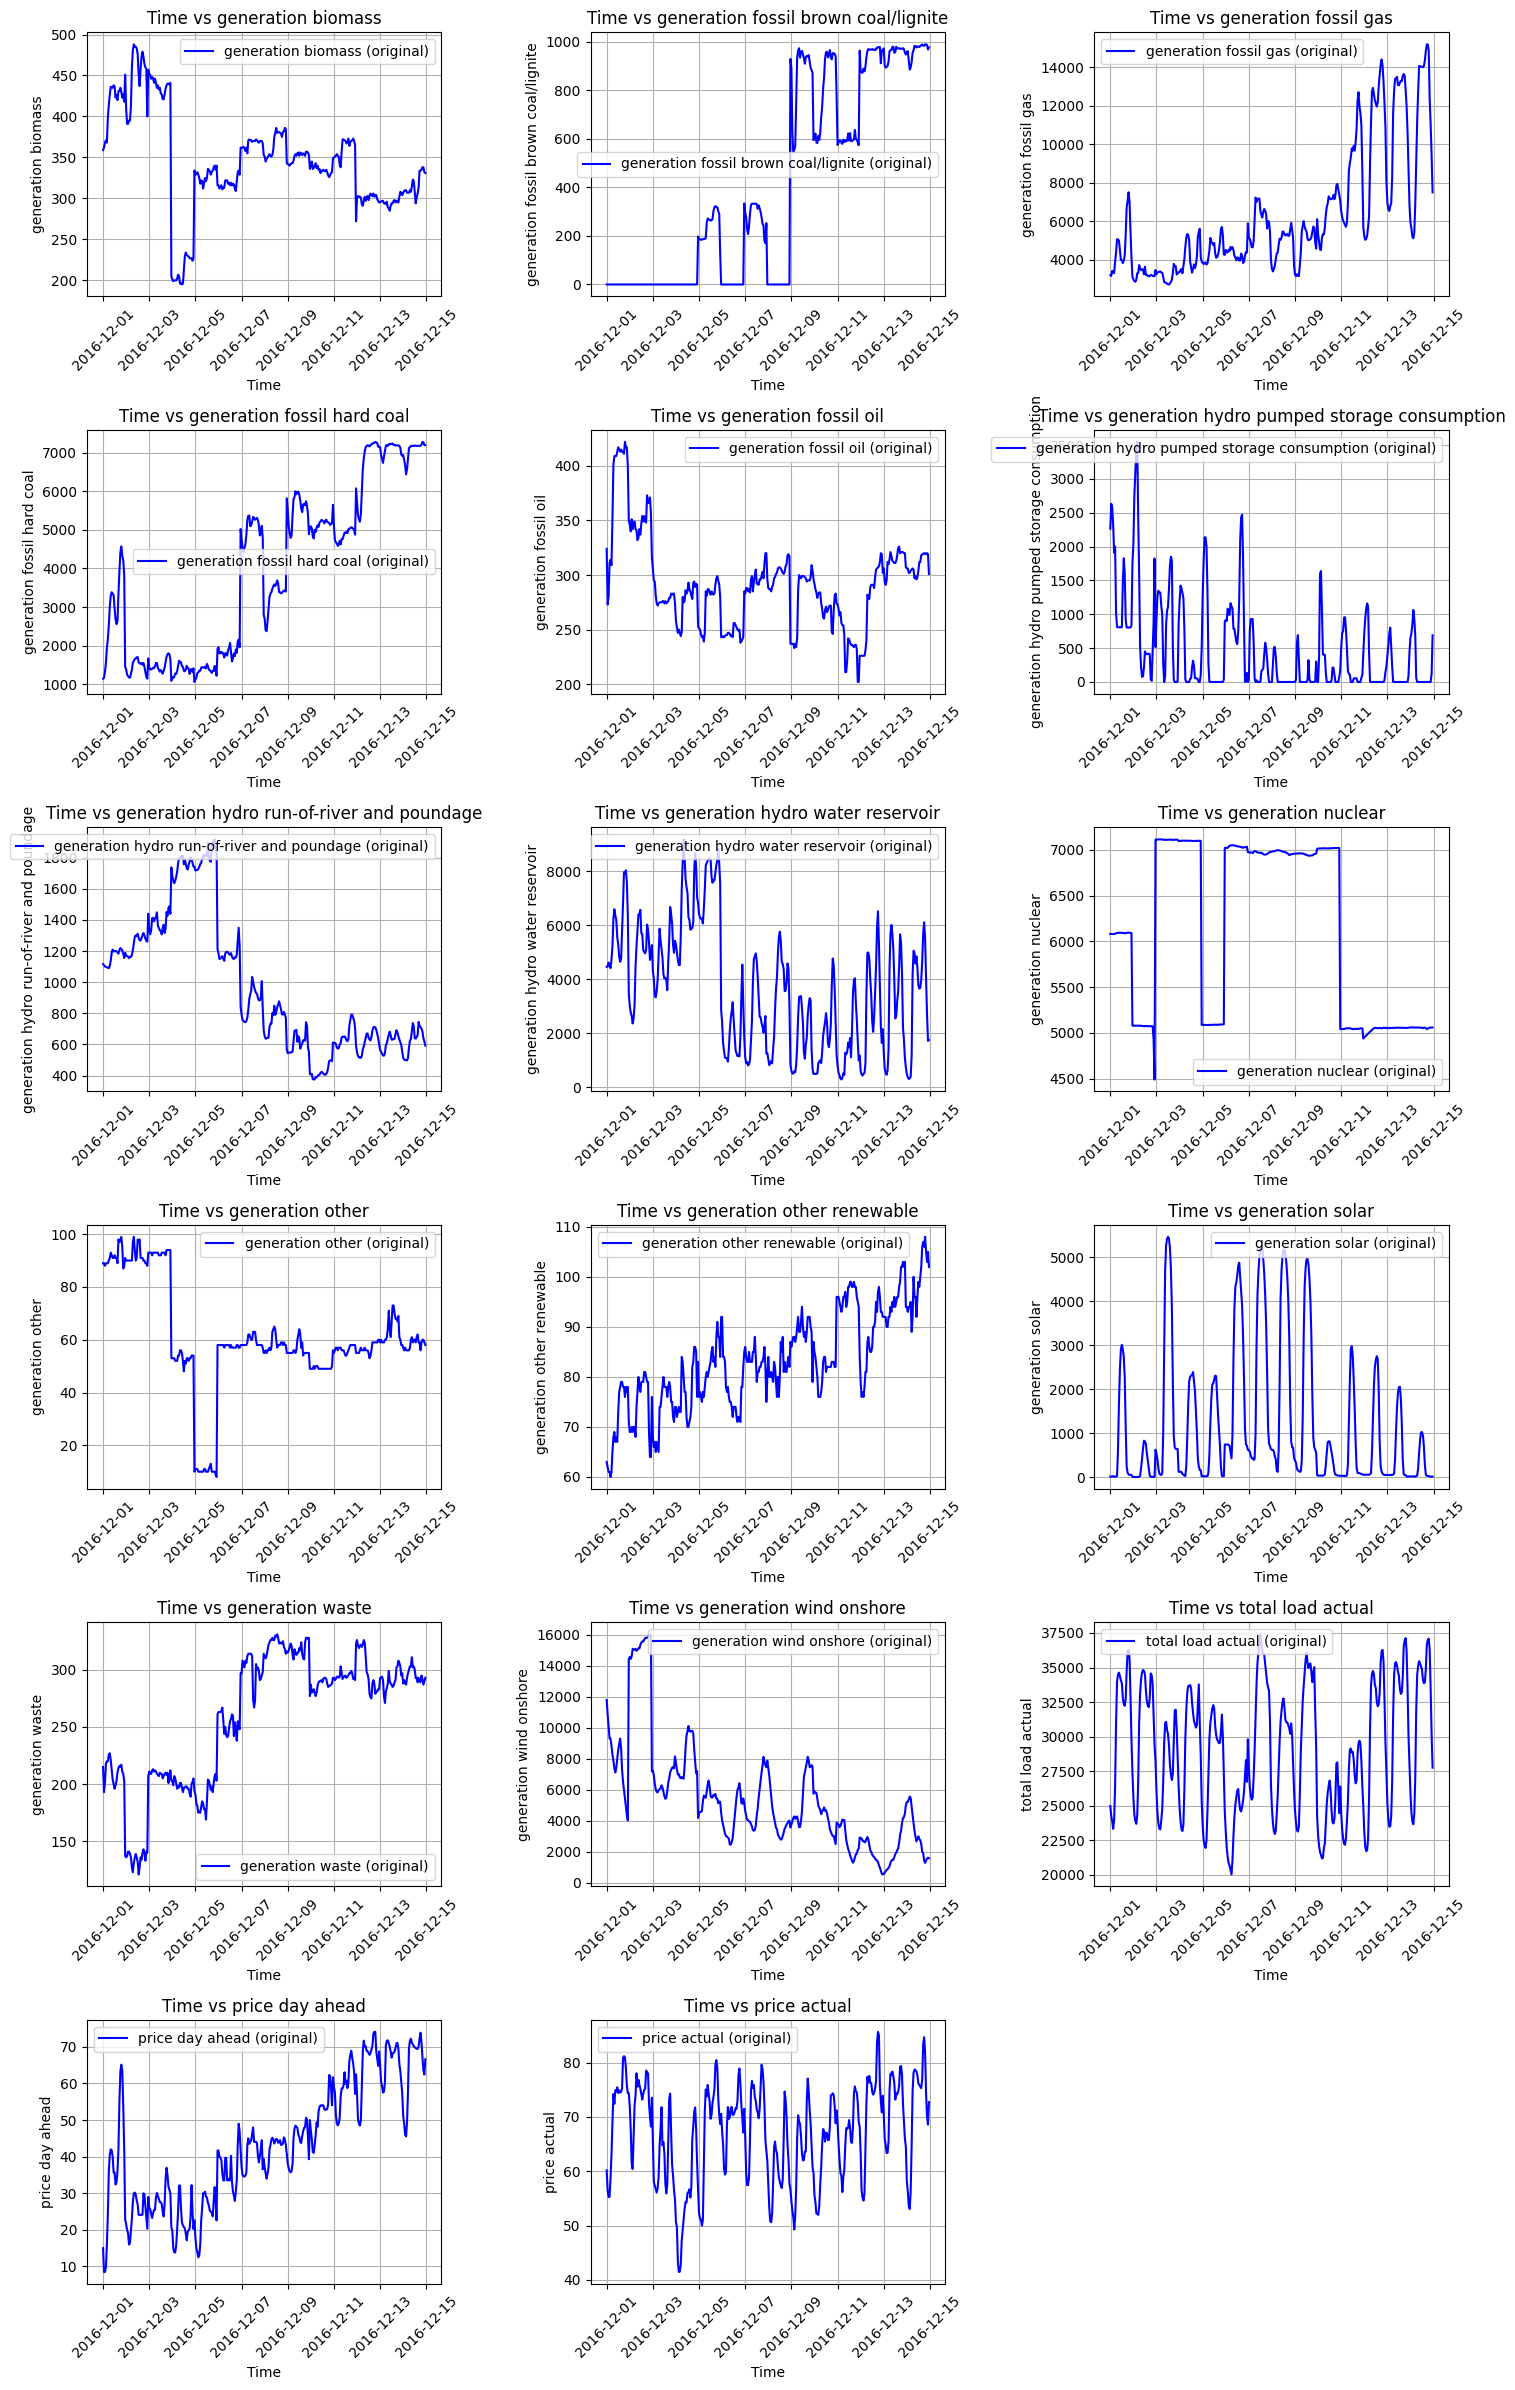

In [11]:
start_date = pd.Timestamp('2016-12-01 00:00:00', tz='UTC')
end_date = pd.Timestamp('2016-12-14 23:59:59', tz='UTC')

# Filter the DataFrame to include only the specific two-week period
df_two_weeks = df_energy.loc[start_date:end_date]
df_two_weeks.head()

# Get the number of columns to plot
columns = df_two_weeks.columns
n_columns = len(columns)

# Calculate the grid size
nrows = math.ceil(n_columns / 3)  # 3 columns per row
ncols = 3  # Fixed number of columns

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 4))
axes = axes.flatten()  # Flatten to easily iterate over

for i, column in enumerate(columns):
    ax = axes[i]
    ax.plot(df_two_weeks.index, df_two_weeks[column], label=f"{column} (original)", color='blue')
    
    # Customize the plot
    ax.set_title(f"Time vs {column}")
    ax.set_xlabel("Time")
    ax.set_ylabel(f"{column}")
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

### Linear Interpolation for Missing Values

After plotting all the features and examining the time-series data, it appears that linear interpolation is the most suitable method to fill in the missing values. Linear interpolation works by estimating missing values based on the linear trend between available data points, making it a natural choice for time-series data where values are expected to change gradually over time.

By applying linear interpolation, we are ensuring that the filled values follow the same trend as the surrounding data points, rather than introducing artificial patterns or assumptions. This method is effective when the data does not exhibit sharp fluctuations or irregular patterns that would require more complex imputation methods, like polynomial or spline interpolation.

Thus, we use the `interpolate()` function with the `linear` method to fill the missing values and preserve the continuity of the time-series data.


In [12]:
df_energy = df_energy.interpolate(method='linear')

In [13]:
null_percentage = df_energy.isnull().sum()/len(df_energy) * 100   
print(null_percentage)
# we can see there is no more missing values in the dataset

generation biomass                             0.0
generation fossil brown coal/lignite           0.0
generation fossil gas                          0.0
generation fossil hard coal                    0.0
generation fossil oil                          0.0
generation hydro pumped storage consumption    0.0
generation hydro run-of-river and poundage     0.0
generation hydro water reservoir               0.0
generation nuclear                             0.0
generation other                               0.0
generation other renewable                     0.0
generation solar                               0.0
generation waste                               0.0
generation wind onshore                        0.0
total load actual                              0.0
price day ahead                                0.0
price actual                                   0.0
dtype: float64


In [14]:
zeros_percentage = (df_energy == 0).sum()/len(df_energy) * 100
print(zeros_percentage)

generation biomass                              0.011408
generation fossil brown coal/lignite           30.014545
generation fossil gas                           0.002852
generation fossil hard coal                     0.008556
generation fossil oil                           0.008556
generation hydro pumped storage consumption    35.975245
generation hydro run-of-river and poundage      0.008556
generation hydro water reservoir                0.008556
generation nuclear                              0.008556
generation other                                0.011408
generation other renewable                      0.008556
generation solar                                0.008556
generation waste                                0.008556
generation wind onshore                         0.008556
total load actual                               0.000000
price day ahead                                 0.000000
price actual                                    0.000000
dtype: float64



## Data Cleaning Summary: df_energy Dataset
Generation fossil brown coal/lignite: This column represents electricity production from lignite, a low-grade coal. While it is an affordable and locally abundant energy source, it is among the least environmentally friendly due to high carbon emissions and inefficiency. Spain's significant investments in renewable energy sources, such as wind, solar, and hydropower, have reduced reliance on lignite. As a result, its use is often limited to periods when renewable generation and other cleaner options cannot meet demand, explaining the presence of zeros in 30% of the data.

Hydro pumped storage consumption: This column shows 35% zeros, which is expected. Pumped storage is utilized only during energy surplus periods to store energy, remaining inactive when supply and demand are balanced or when conditions do not require its operation.

The percentage of zeros in these columns is reasonable and does not indicate any inaccuracies in the data.

With these steps, the df_energy dataset is sufficiently cleaned for further analysis. Future work may include additional feature engineering and processing as needed.

Now, let's proceed to clean the weather dataset.

In [15]:
df_weather.describe()

temp       temp_min       temp_max      pressure  \
count  178391.000000  178391.000000  178391.000000  1.783910e+05   
mean      289.619085     288.330886     291.091788  1.069262e+03   
std         8.025757       7.955117       8.611972  5.969716e+03   
min       262.240000     262.240000     262.240000  0.000000e+00   
25%       283.670000     282.485000     284.650000  1.013000e+03   
50%       289.150000     288.150000     290.150000  1.018000e+03   
75%       295.150000     293.730750     297.150000  1.022000e+03   
max       315.600000     315.150000     321.150000  1.008371e+06   

            humidity     wind_speed       wind_deg        rain_1h  \
count  178391.000000  178391.000000  178391.000000  178391.000000   
mean       68.423065       2.470573     166.592070       0.075494   
std        21.902944       2.095895     116.611933       0.398853   
min         0.000000       0.000000       0.000000       0.000000   
25%        53.000000       1.000000      55.000000       0.000000   
50%        72.000000       2.000000     177.000000       0.000000   
75%        87.000000       4.000000     270.000000       0.000000   
max       100.000000     133.000000     360.000000      12.000000   

             rain_3h        snow_3h     clouds_all     weather_id  
count  178391.000000  178391.000000  178391.000000  178391.000000  
mean        0.000380       0.004763      25.073995     759.830776  
std         0.007289       0.222607      30.774274     108.734538  
min         0.000000       0.000000       0.000000     200.000000  
25%         0.000000       0.000000       0.000000     800.000000  
50%         0.000000       0.000000      20.000000     800.000000  
75%         0.000000       0.000000      40.000000     801.000000  
max         2.315000      21.500000     100.000000     804.000000

In the data set we have 5 major cities in Spain that been sampled through 2014-2018, as we can see they have been sampled hourly, the same as the df_energy dataset which is excellent for us.
The length of the dataframes is 178396 which is 35064(the lenght of the df_energy dataset) * 5.

as we can see here -


In [16]:
print(len(df_energy.index.unique()))
print(len(df_weather.index.unique()))

35063
35063


As we know, in time-series data, duplicates are not allowed. Additionally, when extracting each city as its own feature, duplicates can cause issues. 

In this case, we observe that the total number of unique rows is 35,064, but for each city, we have more than 35,064 rows. This indicates that duplicates exist, and we need to remove them in order to proceed correctly.


In [17]:
grouped = df_weather.groupby('city_name')
# Iterate over each group (city_name) and its corresponding DataFrame
def count_duplicate_times_by_city(grouped):
    for city, group in grouped:
    # Check for duplicates in the 'time' column
        duplicated_count = group['time'].duplicated().sum()
        print(f"City: {city}, Number of duplicated rows based on 'time': {duplicated_count}")
        print(f"Number of rows is {len(group)}")
        duplicated_rows = group[group['time'].duplicated(keep=False)]
count_duplicate_times_by_city(grouped)


City:  Barcelona, Number of duplicated rows based on 'time': 412
Number of rows is 35475
City: Bilbao, Number of duplicated rows based on 'time': 887
Number of rows is 35950
City: Madrid, Number of duplicated rows based on 'time': 1203
Number of rows is 36266
City: Seville, Number of duplicated rows based on 'time': 493
Number of rows is 35556
City: Valencia, Number of duplicated rows based on 'time': 81
Number of rows is 35144


In [18]:
# Group by 'time' and 'city_name' and filter for groups that have more than one row
duplicated_rows = df_weather[df_weather.duplicated(subset=['time', 'city_name'], keep=False)]

# Display the rows
print(duplicated_rows.head(10))


                          city_name     temp  temp_min  temp_max  pressure  \
time                                                                         
2015-01-06 03:00:00+00:00  Valencia  273.142   273.142   273.142       995   
2015-01-06 03:00:00+00:00  Valencia  273.142   273.142   273.142       995   
2015-06-15 19:00:00+00:00  Valencia  289.610   288.650   290.930      1018   
2015-06-15 19:00:00+00:00  Valencia  289.610   288.650   290.930      1018   
2015-06-15 20:00:00+00:00  Valencia  289.240   288.150   290.370      1018   
2015-06-15 20:00:00+00:00  Valencia  289.240   288.150   290.370      1018   
2015-07-18 17:00:00+00:00  Valencia  299.770   298.750   300.930      1013   
2015-07-18 17:00:00+00:00  Valencia  299.770   298.750   300.930      1013   
2015-07-31 21:00:00+00:00  Valencia  295.890   293.710   297.590      1009   
2015-07-31 21:00:00+00:00  Valencia  295.890   293.710   297.590      1009   

                           humidity  wind_speed  wind_deg  rain

As we can see, and after some manual(is it enough?) digging, The duplicated row mostly have the same values for the other columns.
so I will drop duplicates with keeping the first row(meaning that we will delete all the other rows that have the same 'time' and 'city_name')

In [19]:

df_weather = df_weather.drop_duplicates(subset=['time', 'city_name'], keep='last')  # Keep the last occurrence


In [20]:
grouped = df_weather.groupby('city_name')
# Iterate over each group (city_name) and its corresponding DataFrame
def count_duplicate_times_by_city(grouped):
    for city, group in grouped:
    # Check for duplicates in the 'time' column
        duplicated_count = group['time'].duplicated().sum()
        print(f"City: {city}, Number of duplicated rows based on 'time': {duplicated_count}")
        print(f"Number of rows is {len(group)}")
        duplicated_rows = group[group['time'].duplicated(keep=False)]

count_duplicate_times_by_city(grouped)
    

City:  Barcelona, Number of duplicated rows based on 'time': 0
Number of rows is 35063
City: Bilbao, Number of duplicated rows based on 'time': 0
Number of rows is 35063
City: Madrid, Number of duplicated rows based on 'time': 0
Number of rows is 35063
City: Seville, Number of duplicated rows based on 'time': 0
Number of rows is 35063
City: Valencia, Number of duplicated rows based on 'time': 0
Number of rows is 35063


In [21]:
zeros_percentage = (df_weather == 0).sum()/len(df_weather) * 100
print(zeros_percentage)

city_name               0.000000
temp                    0.000000
temp_min                0.000000
temp_max                0.000000
pressure                0.001141
humidity                0.035935
wind_speed             10.335681
wind_deg               13.889285
rain_1h                90.079571
rain_3h                98.942475
snow_3h                99.847703
clouds_all             46.776374
weather_id              0.000000
weather_main            0.000000
weather_description     0.000000
weather_icon            0.000000
time                    0.000000
dtype: float64


as we can see, the rain_3h(3 hours of raining) is a data that already contanied in the rain_1h(1 hour of raining), so, to remove the redundancy we will remove it.
also, we will take a look at the other columns and figure out if there is some more cleaning we need to do.

In [22]:
df_weather = df_weather.drop(['rain_3h'],axis=1)
# df_weather.info()
# we see that there is some float64 and there is some int64, we will convert the int64 to float64
for col in df_weather.select_dtypes(include=['int64']).columns:
    df_weather[col] = df_weather[col].astype('float64')
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175315 entries, 2015-01-01 00:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   city_name            175315 non-null  object             
 1   temp                 175315 non-null  float64            
 2   temp_min             175315 non-null  float64            
 3   temp_max             175315 non-null  float64            
 4   pressure             175315 non-null  float64            
 5   humidity             175315 non-null  float64            
 6   wind_speed           175315 non-null  float64            
 7   wind_deg             175315 non-null  float64            
 8   rain_1h              175315 non-null  float64            
 9   snow_3h              175315 non-null  float64            
 10  clouds_all           175315 non-null  float64            
 11  weather_id         

All the columns but weather_id,weather_meain,weather dscription and weather_icon and very self-explanibale. 
so now we will try to understand what information each of these columns give us and we need them all.
if we look at the data bases in the kaggle there is a brief explantion for each column.
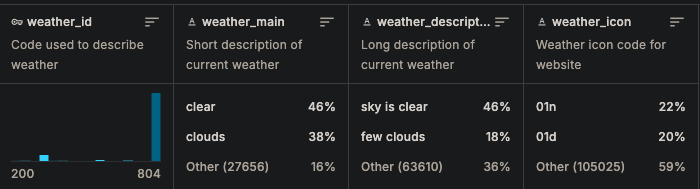



In this step, we encode the categorical features `weather_main` and `weather_description` in the `df_weather` DataFrame using `LabelEncoder`. This transformation converts the textual weather descriptions into numeric labels, making them suitable for correlation analysis and machine learning algorithms.

We print the unique encoded values for both `weather_main` and `weather_description` to understand the range of the encoded labels. Then, we calculate the correlation between `weather_main` and `weather_id` to check if these features convey similar information.

Since the correlation between `weather_main` and `weather_id` is very high, we decide to drop the `weather_id` column to avoid redundancy. Additionally, we drop the `weather_icon` column as it is not relevant for our analysis, and the `weather_description` column because its high specificity could lead to overfitting in our model.

This preprocessing step ensures that we retain only the most informative features while reducing potential noise and redundancy in our dataset.


In [23]:

le = LabelEncoder()
# Encode categorical features
df_weather['weather_main'] = le.fit_transform(df_weather['weather_main'])
df_weather['weather_description'] = le.fit_transform(df_weather['weather_description'])

# Print the correlation between `weather_main` and `weather_id`
print(f"Correlation between weather_main and weather_id: {df_weather['weather_main'].corr(df_weather['weather_id'])}")

# as we can see the correlation is very high, we will drop the weather_id column, also the weather_icon column(not relevant for us) and weathers_description(too much specific can give us overfitting)
df_weather = df_weather.drop(['weather_id', 'weather_icon', 'weather_description'], axis=1)


Correlation between weather_main and weather_id: -0.8783430726614807



In this step, we prepare the dataset for correlation analysis by dropping non-numeric columns such as `city_name` and `time`, which are not relevant for correlation computation. We then calculate the correlation matrix for the remaining features in the `df_weather` DataFrame.

To visualize the correlations, we plot a heatmap using `seaborn`. The heatmap displays the correlation coefficients between different features, with values ranging from -1 to 1. A correlation close to 1 indicates a strong positive relationship, while a correlation close to -1 indicates a strong negative relationship. Values near 0 suggest no linear relationship.

The purpose of this correlation map is to identify features that are highly correlated with each other. When two features have a high correlation, one of them can often be dropped without losing much information. This step helps in reducing multicollinearity, simplifying the model, and improving its performance by retaining only the most informative features.


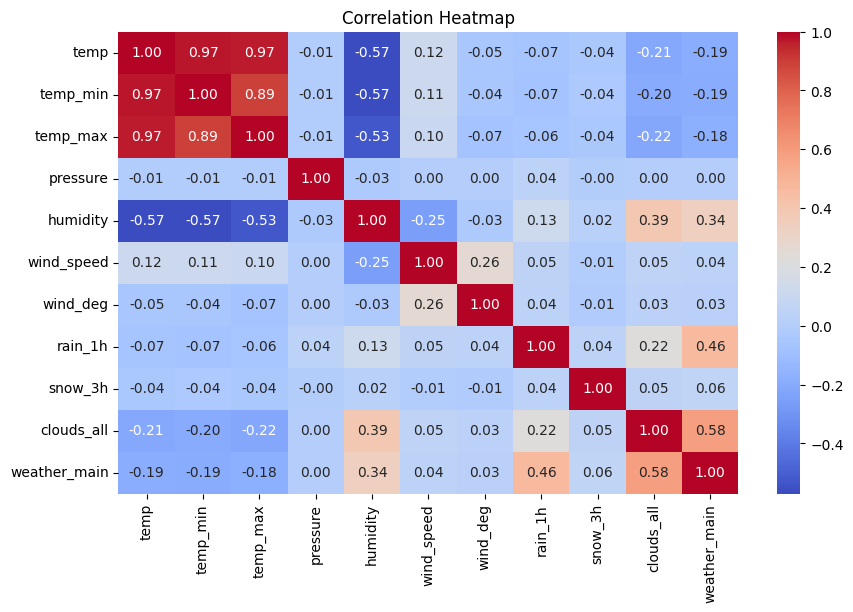

In [24]:
df_for_cor = df_weather.drop(['city_name','time'],axis=1)
corr = df_for_cor.corr()
# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

we can see that temp min and temp max are very correlated and not adding any information(makes sense) so we will drop them.

In [25]:
df_weather.drop(['temp_min','temp_max'],axis=1,inplace=True)



In this step, we create boxplots for each numerical feature in the `df_weather` DataFrame. Boxplots are a useful visualization tool for identifying potential outliers within a dataset. They display the distribution of data points and highlight the median, quartiles, and any values that lie significantly outside the interquartile range (IQR).

We begin by selecting all numerical columns (`float64` and `int64` types) and determining the grid size for plotting, aiming for a clean layout with 4 columns per row. We then create subplots for each numerical feature, plotting individual boxplots with `seaborn`. The boxplots are colored consistently to maintain visual uniformity.

By visualizing all numerical features in this way, we can quickly identify which features contain outliers, allowing us to decide whether to address these outliers through methods such as data transformation, removal, or imputation.

This step is crucial for improving the robustness of our model by ensuring that extreme values do not skew the results or lead to inaccurate predictions.


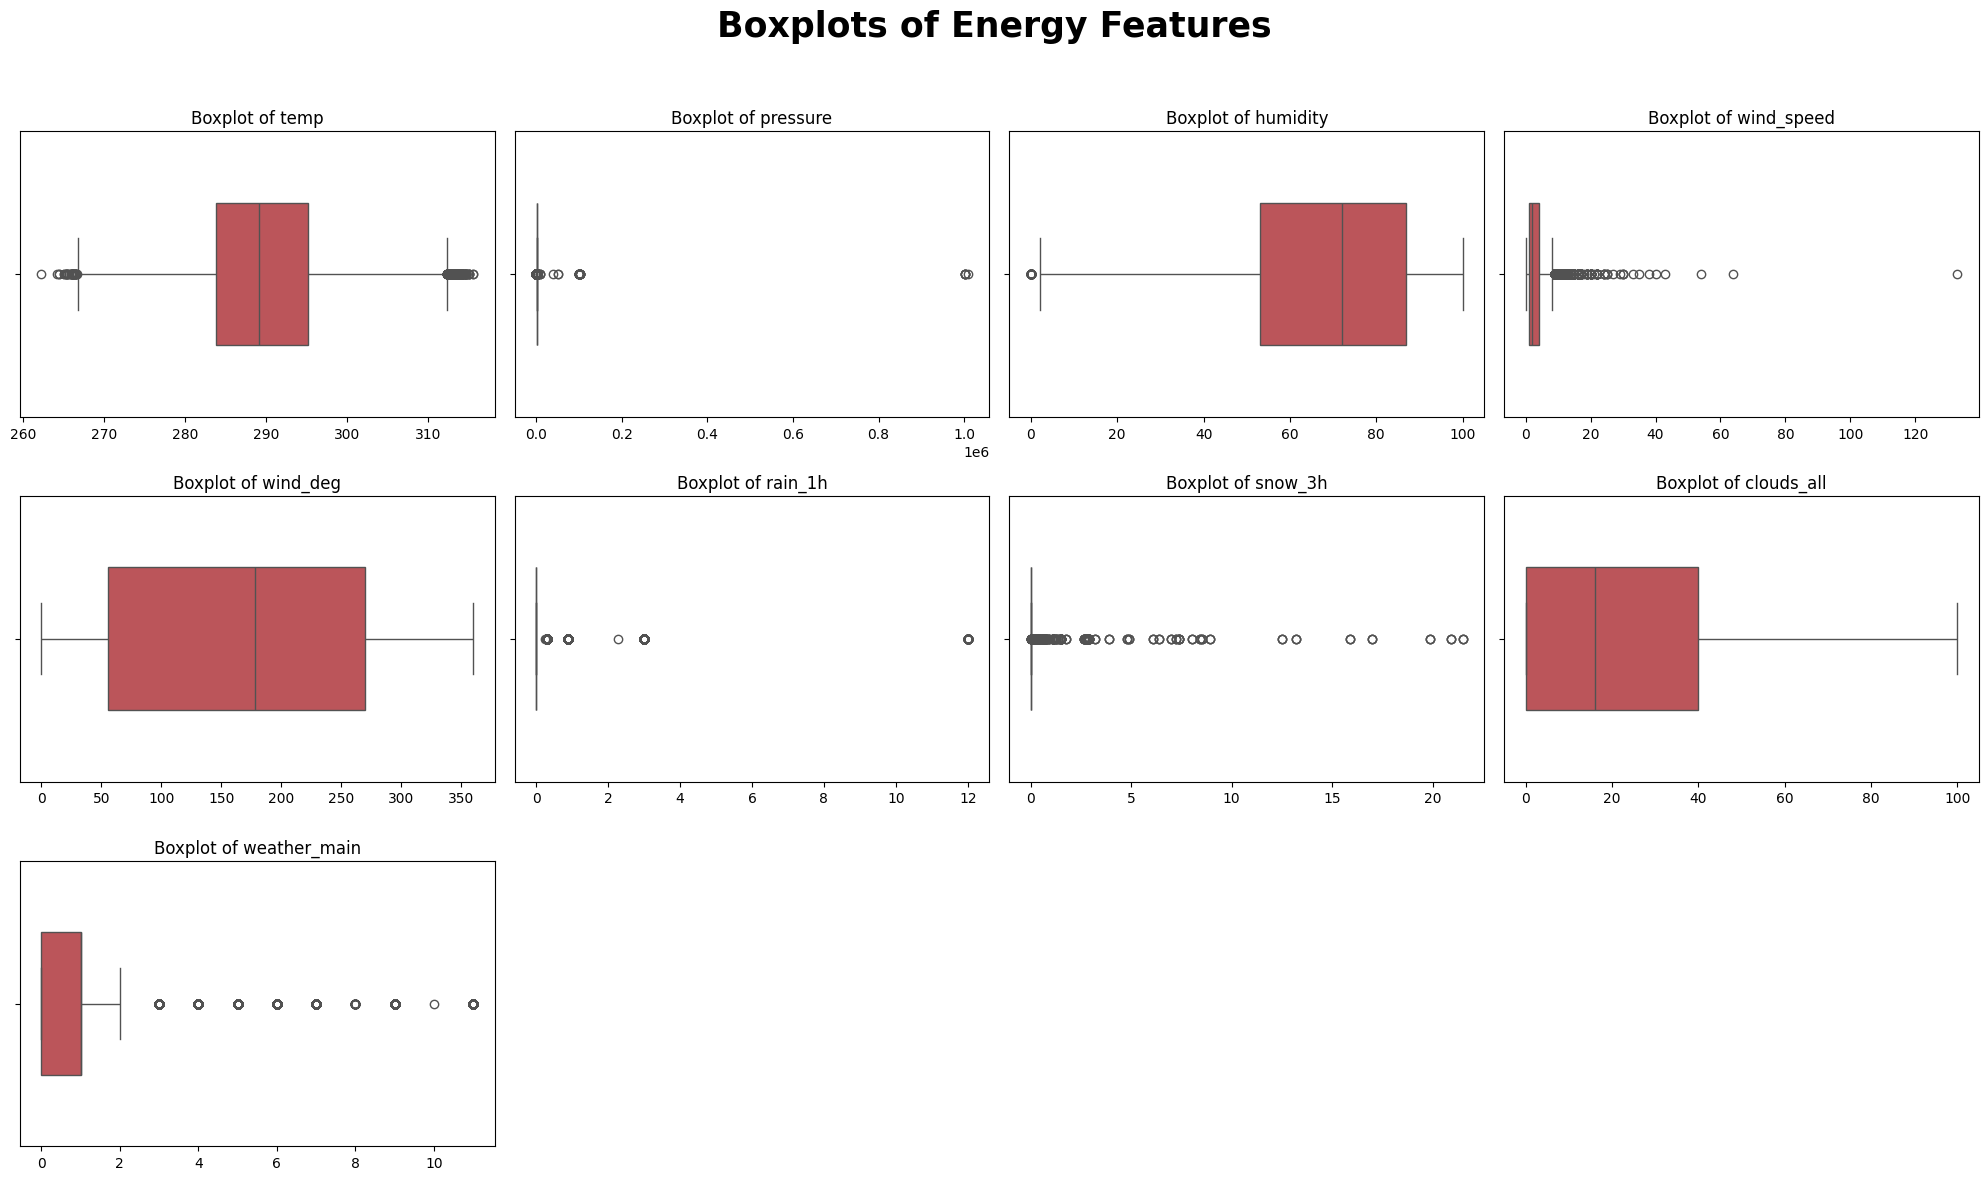

In [26]:
# Select numerical columns for plotting
columns = df_weather.select_dtypes(include=['float64', 'int64']).columns

# Calculate grid size (e.g., 2 columns per row)
ncols = 4
nrows = int(np.ceil(len(columns) / ncols))

# Create subplots
f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
f.suptitle('Boxplots of Energy Features', weight='bold', fontsize=25)

# Flatten axes array and iterate over columns
axes = axes.flatten()
for i, col in enumerate(columns):
    sns.boxplot(data=df_weather, x=col, ax=axes[i], color='#cc444b', width=0.5)
    axes[i].set_title(f"Boxplot of {col}", fontsize=12)
    axes[i].set_xlabel('')  # Remove x-axis label for cleanliness

# Remove unused subplots if columns are fewer than grid slots
for j in range(i + 1, len(axes)):
    f.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()

The normal pressure level at sea level is about 1000 hPa, at the dead sea, where is the higgest known in the world, pressure is about 1100 hPa, so more then that its an outlier. and less then 700 hPa also outlier.
also, wind speed is in m/s, then to have 50 m/s is a high as 180 km/h wind, which is very very high. so, we will define wind more then 50 m/s is an outlier.
for presure we will use mean because pressure have a solid values who are not range so much.
for wind we will calculate the 95th percentile of wind speed and if its more then the 99 percentile we will replace the value to be the 95 percentile.

In [27]:
mean_pressure = df_weather['pressure'].mean()
df_weather.loc[df_weather['pressure'] > 1105, 'pressure'] = mean_pressure
df_weather.loc[df_weather['pressure'] < 700, 'pressure'] = mean_pressure
# Calculate the 95th percentile of wind speed


upper_limit = np.percentile(df_weather['wind_speed'], 99)

# Replace values above the 95th percentile with the 95th percentile value
df_weather.loc[df_weather['wind_speed'] > upper_limit, 'wind_speed'] = upper_limit


All the other features doesnt seem to have a not reasonable outlier. so we will keep them.

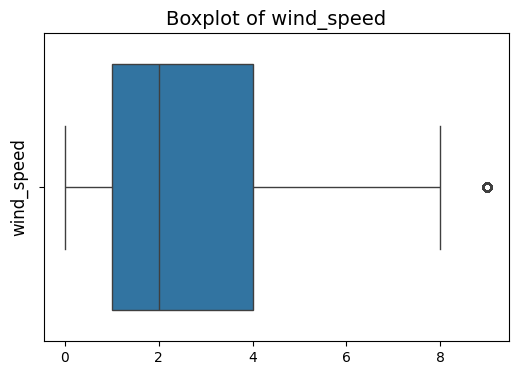

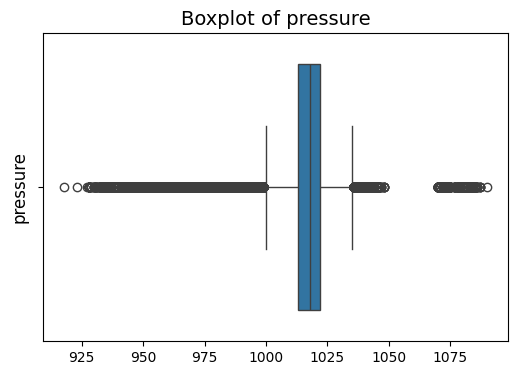

In [28]:
# Select numerical columns for plotting
columns = df_weather[['wind_speed','pressure']]

# Loop through each column and create a boxplot
for column in columns:
    plt.figure(figsize=(6, 4))  # Set the figure size
    sns.boxplot(x=df_weather[column])
    
    # Customize the plot
    plt.title(f'Boxplot of {column}', fontsize=14)
    plt.ylabel(column, fontsize=12)
    plt.xlabel('')  # No need for an x-axis label as it's a single feature
    
    # Show the plot
    plt.show()


We merge the weather data for each city with the energy dataset to add each city as a distinct "feature." This process creates a comprehensive final dataset where each city's weather conditions are uniquely represented. By doing so, we can analyze the impact of localized weather patterns on energy consumption and production. This enriched dataset will later be combined with energy costs, providing a robust framework for understanding the relationship between weather, energy usage, and economic factors across different regions.


In [29]:
# Get the unique cities
cities = df_weather['city_name'].unique()

# Create a dictionary to store DataFrames for each city
city_datasets = {city: df_weather[df_weather['city_name'] == city].copy() for city in cities}

# Reset index once for each city dataframe
for city, city_df in city_datasets.items():

    city_df.drop(['time'],axis=1,inplace=True)
    for col in city_df:
        city_df[f"{col}_{city}"] = city_df[col]
        city_df.drop(col, axis=1, inplace=True)

# Reset index for the merged dataframe as well
merged_df = df_energy.copy()

# Merge city dataframes with the energy dataframe
for city, city_df in city_datasets.items():
    merged_df = pd.merge(merged_df, city_df,left_index=True,right_index=True, how='outer')
    

# Ensure the index is in datetime format
merged_df.index = pd.to_datetime(merged_df.index)
# Set the frequency of the index to hourly
merged_df = merged_df.asfreq('h')


### Exploring Seasonality in Time Series Data

In time series analysis, understanding the seasonality of the data is crucial as it allows us to identify recurring patterns over specific periods. To capture these seasonal effects, we can explore trends at different time granularities such as monthly, hourly, and daily patterns. This analysis helps determine whether these temporal features should be included in our model to improve forecasting accuracy.
for example, it makes sense that the price at the night will be lower then in the day.
 Below, we analyze the seasonality by plotting the trends for different time segments.

#### Monthly Trends by Year

This graph allows us to observe patterns and variations in the `price actual` over different months for each year. If a consistent pattern emerges across years, it indicates monthly seasonality, which can be leveraged as a feature in our model.


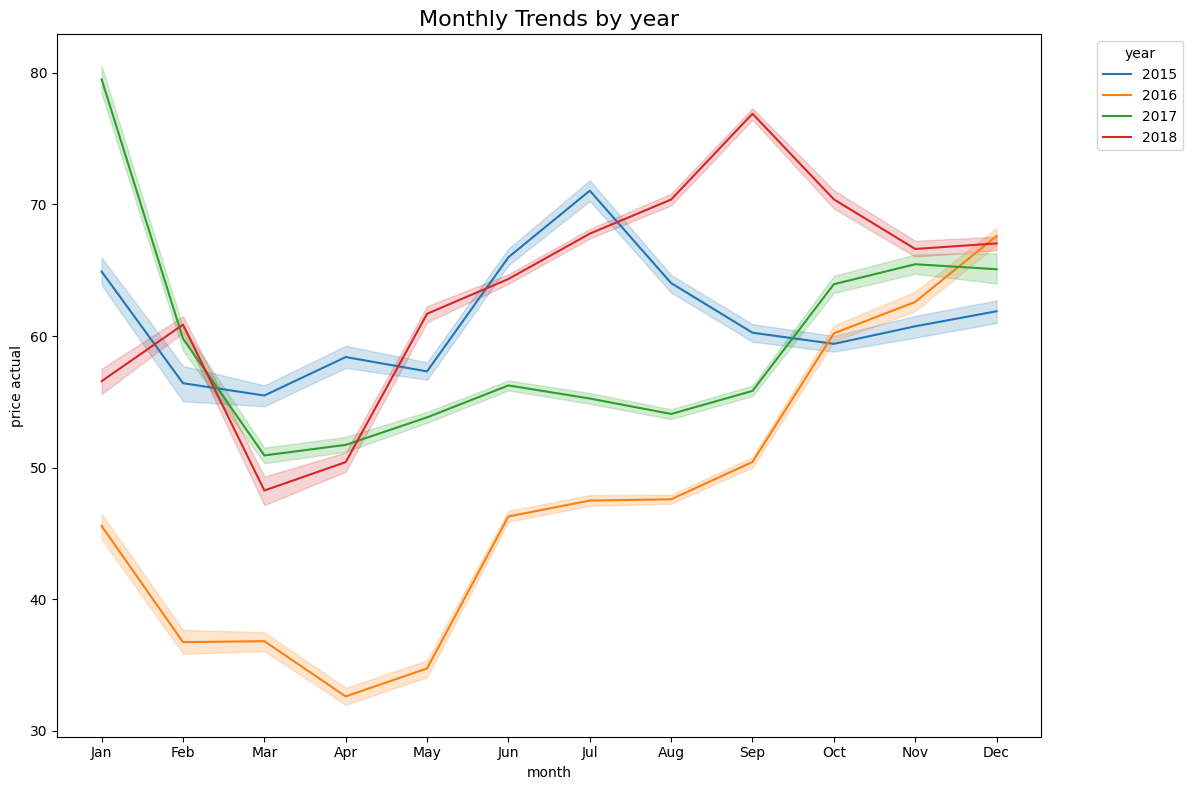

In [30]:

# Create a new column for Year and Month
merged_df['year'] = merged_df.index.year
merged_df['month'] = merged_df.index.strftime('%b')  # Extract month names (e.g., "Jan", "Feb")

# Ensure the months are sorted in order
merged_df['month'] = pd.Categorical(merged_df['month'], 
                              categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
                              ordered=True)
merged_df.columns
# Create the line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=merged_df, x='month', y='price actual', hue='year', palette='tab10', legend='full')

# Customize the plot
plt.title('Monthly Trends by year', fontsize=16)
plt.xlabel('month')
plt.ylabel('price actual')
plt.legend(title='year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### Hourly Trends by Year

This plot highlights the variations in `price actual` at different hours of the day across several years. as we can see there is regular patterns during certain hours and that could suggest daily seasonality, which can improve the model's predictive capability if included as a feature.


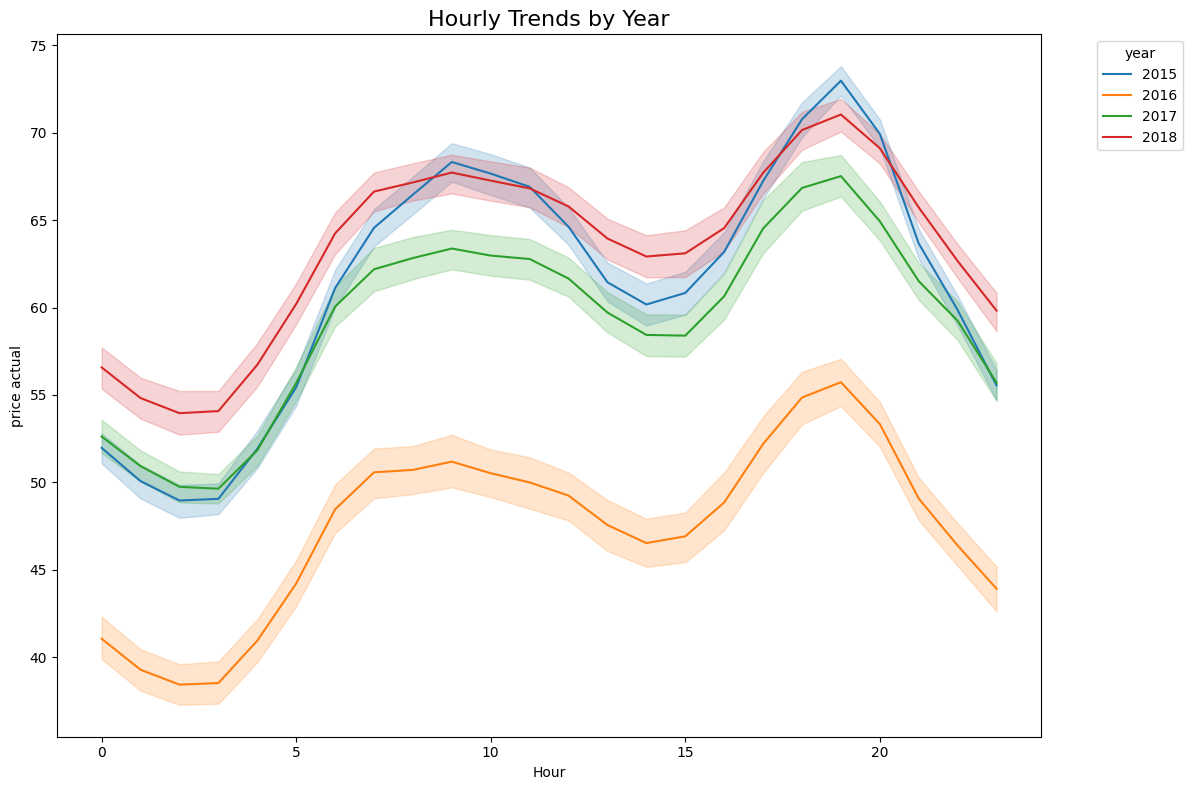

In [31]:

# If you already have a DatetimeIndex:
# Create a new column for Year and Month
merged_df['hour'] = merged_df.index.hour

# merged_df.columns
# # Create the line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=merged_df, x='hour', y='price actual', hue='year', palette='tab10', legend='full')

# Customize the plot
plt.title('Hourly Trends by Year', fontsize=16)
plt.xlabel('Hour')
plt.ylabel('price actual')
plt.legend(title='year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### Daily Trends by Year

This graph illustrates the `price actual` across different days of the week for each year. If specific days consistently show higher or lower prices, this day-of-week seasonality can be incorporated into the model to enhance its accuracy.


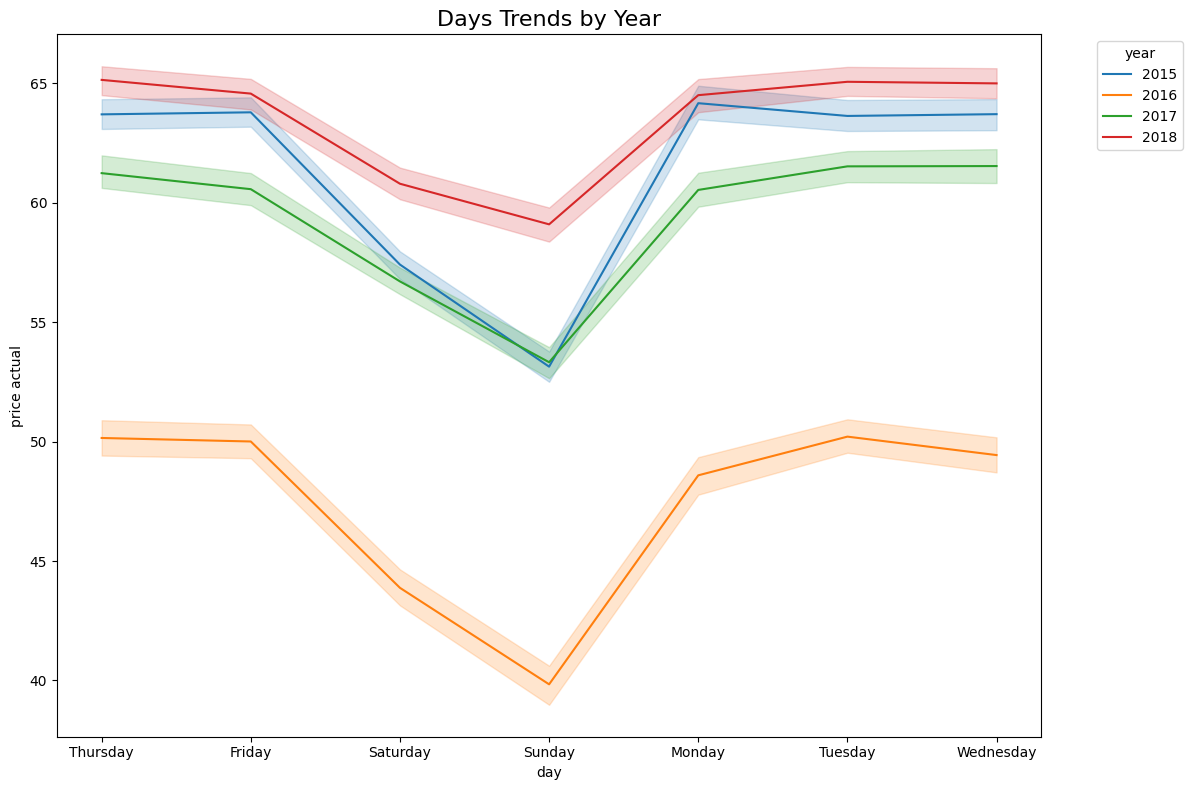

In [32]:
# Extract the day of the week
merged_df['day'] = merged_df.index.strftime('%A')  # Full day name (e.g., "Monday", "Tuesday")


# merged_df.columns
# # Create the line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=merged_df, x='day', y='price actual', hue='year', palette='tab10', legend='full')

# Customize the plot
plt.title('Days Trends by Year', fontsize=16)
plt.xlabel('day')
plt.ylabel('price actual')
plt.legend(title='year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



**Conclusion:**  
We found seasonality in all these time segments, which makes sense given the nature of electricity usage. For example, fewer people use electricity during the night, leading to lower demand, while seasonal changes, such as increased heating in winter, affect energy consumption patterns, or Of course that will be less energy consumption in sunday and there for the actual price will be lower. By identifying these seasonal trends, we can include them as features in our model to improve its accuracy and reliability.








I plan to incorporate additional features, such as CPI (Inflation), to enhance the model. However, feature engineering can be an endless process, so I’ve decided to move forward with the current setup and revisit feature engineering after the initial evaluation.

### Stationarity in Time-Series Data  

Stationarity is a fundamental concept in time-series forecasting. A time series is considered **stationary** if its statistical properties—such as mean, variance, and autocorrelation—remain constant over time. Many forecasting models, including ARIMA, rely on stationarity to produce accurate predictions.  

#### Why is Stationarity Important?  

1. **Model Assumptions**: Many traditional time-series models assume stationarity because it simplifies analysis and improves forecast reliability. Non-stationary data can lead to misleading results and unstable predictions.  
2. **Predictability**: A stationary time series is easier to analyze and forecast since its past patterns are more likely to persist in the future.  
3. **Transformation Requirement**: If a time series is non-stationary, transformations such as **differencing**, **log transformation**, or **seasonal adjustments** are often required to make it stationary before applying forecasting models.  

### Augmented Dickey-Fuller (ADF) Test  

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a given time series is stationary or non-stationary. A stationary time series has properties like mean, variance, and autocorrelation that are constant over time, which is a crucial assumption for many time series forecasting models.  

#### Why Perform the ADF Test?  

1. **Stationarity Check**: Many time series models, such as ARIMA, require the series to be stationary to provide reliable forecasts. If the series is not stationary, the model may yield biased or inaccurate results.  
2. **Differencing Decision**: If the ADF test indicates that the series is non-stationary, it might be necessary to transform the series (e.g., by differencing) to make it stationary before modeling.  
3. **Understanding Trends**: The test helps to confirm whether trends or seasonality in the data are influencing its statistical properties over time.  

#### Interpreting ADF Test Results:  

- **Test Statistic**: A negative value indicates a tendency towards stationarity.  
- **p-value**: If the p-value is less than a chosen significance level (commonly 0.05), we reject the null hypothesis of the test, which states that the time series is non-stationary.  
- **Critical Values**: These are thresholds at different confidence levels. If the test statistic is less than the critical value, the series is considered stationary.  

In this case, performing the ADF test on the `price actual` column of the dataset helps determine if the energy price series is stationary. If not, we may need to transform it before applying time series models.


In [33]:
from statsmodels.tsa.stattools import adfuller

# Define a function to perform the ADF test on a time series
def adf_test(timeseries):
    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
# Perform the ADF test on the 'price actual' column
adf_test(merged_df['price actual'])

Results of Dickey-Fuller Test:
Test Statistic                -9.148003e+00
p-value                        2.734579e-15
#Lags Used                     5.000000e+01
Number of Observations Used    3.501200e+04
Critical Value (1%)           -3.430537e+00
Critical Value (5%)           -2.861623e+00
Critical Value (10%)          -2.566814e+00
dtype: float64


### Augmented Dickey-Fuller (ADF) Test Results

The ADF test was performed to assess the stationarity of the `price actual` time series. Below are the key results:

- **Test Statistic**: -9.148
- **p-value**: \(2.73 \times 10^{-15}\)
- **#Lags Used**: 50
- **Number of Observations Used**: 35,012
- **Critical Values**:
  - 1%: -3.431
  - 5%: -2.862
  - 10%: -2.567

Since the ADF test statistic (-9.148) is significantly less than the critical value at the 1% level (-3.431), we reject the null hypothesis \(H_0\) of the test. This suggests that the time series does not contain a unit root and is thus stationary or can be made stationary with first-order differencing (difference-stationary). This result implies that the `price actual` series is suitable for time series modeling without additional transformation for stationarity.


In [34]:
merged_df['is_weekend'] = merged_df['day'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)


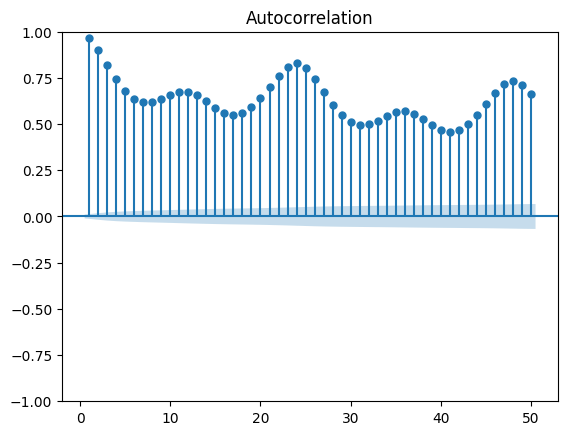

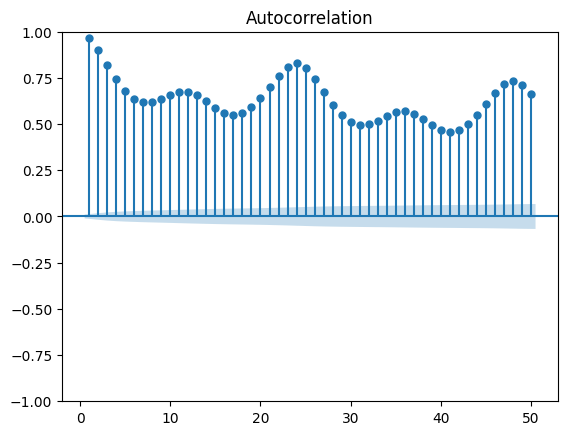

In [35]:
plot_acf(merged_df['price actual'], lags=50, zero=False)

Autocorrelation (ACF) Plot:

The ACF plot shows the correlation between the time series and its lagged values.
In your plot, we observe a significant spike at lag 0, which is expected.
There are also significant spikes at several other lags, suggesting strong autocorrelation.
The ACF plot doesn't cut off sharply, indicating that it might be challenging to identify a clear pattern for the moving average (MA) component.

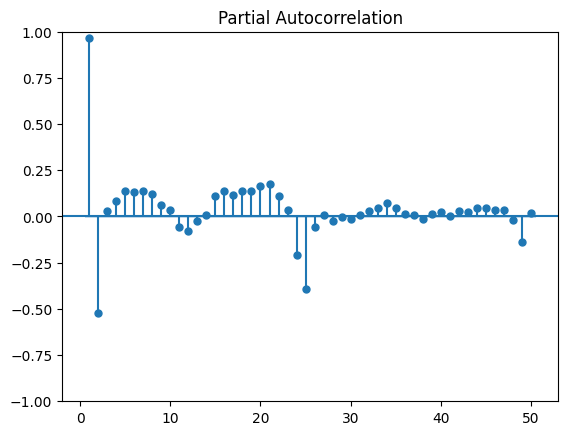

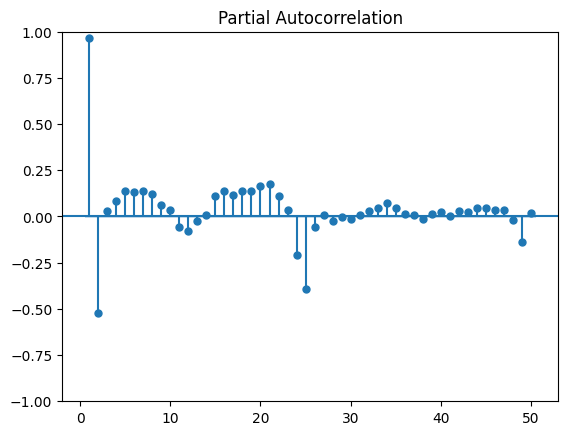

In [36]:
plot_pacf(merged_df['price actual'], lags=50, zero=False)

### Partial Autocorrelation (PACF) Analysis

The PACF plot of the electricity price time series reveals the direct relationship between an observation at a given hour (t) and its lagged values, while controlling for the effects of intermediate lags. Significant correlations are observed at lags t-1, t-2, t-24, and t-25, with the influence diminishing at higher lags. These spikes indicate the relevance of these lags for the autoregressive (AR) component of the model. 

Based on this analysis, we will incorporate the 25 most recent lagged values of the time series as features for our models.
And another important thing, is that we can see there that daily(24-25 hours) and hourly give us signficant correlations and then, we will consdir it later if we will want to add features of hour,days and months.

### Identifying Non-Numeric Columns for Preprocessing

Before training a model, it's essential to ensure that all features are in a numerical format. Many machine learning models do not support categorical or non-numeric data, so we need to identify and preprocess such columns.



In [37]:
merged_df.dtypes.unique()
unwelcome_dtypes = [col for col in merged_df if merged_df[col].dtypes != 'float64' and merged_df[col].dtypes != 'int64']
unwelcome_dtypes

['city_name_Valencia',
 'city_name_Madrid',
 'city_name_Bilbao',
 'city_name_ Barcelona',
 'city_name_Seville',
 'year',
 'month',
 'hour',
 'day']

City names are not a informative feature so we will drop them, and for the year,monnth,hour and day we will LabelEncoder to make them a suitable type for us

In [38]:

encoder = LabelEncoder()

# Fit and transform the 'day' column
merged_df['day'] = encoder.fit_transform(merged_df['day'])
merged_df['year'] = encoder.fit_transform(merged_df['year'])
merged_df['month'] = encoder.fit_transform(merged_df['month'])
merged_df['hour'] = encoder.fit_transform(merged_df['hour'])
unwelcome_dtypes = [col for col in merged_df if merged_df[col].dtypes != 'float64' and merged_df[col].dtypes != 'int64']

merged_df.drop(unwelcome_dtypes, axis=1, inplace=True)


In [39]:
unwelcome_dtypes = [col for col in merged_df if merged_df[col].dtypes != 'float64' and merged_df[col].dtypes != 'int64']
unwelcome_dtypes


[]

## Clustering and PCA for Time-Series Analysis

Now, we will **cluster our time-series data** to uncover patterns and relationships between different features. Clustering helps us identify groups with similar behaviors, which can improve forecasting accuracy. 

After clustering, we will apply **Principal Component Analysis (PCA)** to reduce dimensionality, remove redundancy, and make our dataset more efficient for modeling. PCA helps retain the most important information while simplifying the data structure. but first we will normalize the data


---

## Why Normalize Time-Series Data?

Normalization scales data to a fixed range, ensuring consistency across different features. This prevents variables with larger values from dominating, improves model performance, and speeds up optimization in many machine learning tasks.

## Why Normalize for Clustering?

In clustering, algorithms like **k-means** and **DBSCAN** rely on distance metrics. Without normalization, features with larger ranges can distort clustering results. By using **MinMaxScaler**, we bring all values between **0 and 1**, ensuring each feature contributes equally.




In [40]:
# Define features (X) and target (y)
X = merged_df.drop(columns=['price actual']).values  # Convert to NumPy array
y = merged_df['price actual'].values.reshape(-1, 1)  # Reshape y for scaling

# Initialize scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Scale features and target
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

##  Finding the Optimal Number of Clusters with the Elbow Method  

The **Elbow Method** helps determine the optimal number of clusters (`k`) by analyzing the **Within-Cluster Sum of Squares (WCSS)**. WCSS measures the compactness of clusters—the lower, the better.  

###  How It Works:  
1. Compute **WCSS** for different values of `k`.  
2. Plot `k` vs. WCSS to visualize the "elbow point."  
3. The optimal `k` is where WCSS starts decreasing at a slower rate (the "elbow"), balancing model accuracy and simplicity.  

This method ensures meaningful clustering without overfitting or unnecessary complexity, As we can see 4 or 5 looks like the right number of clustring(from the graph)


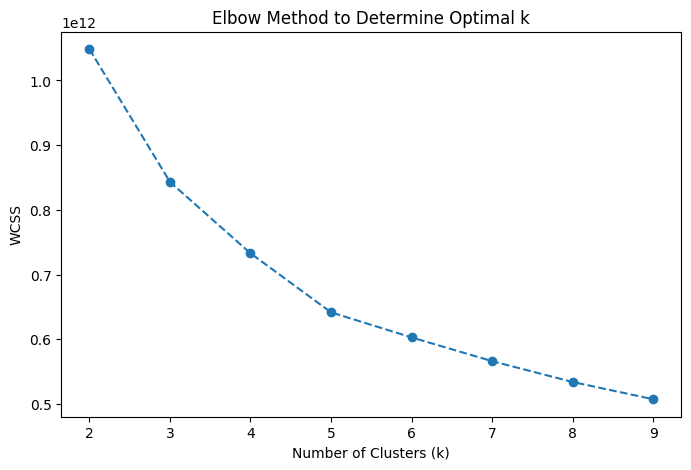

In [41]:
from sklearn.metrics import silhouette_score
# Find optimal number of clusters using Elbow Method
wcss = []  # Within-cluster sum of squares

for k in range(2, 10):  # Try different values of k
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(merged_df)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method to Determine Optimal k")
plt.show()



##  Silhouette Score for Clustering  

The **Silhouette Score** measures how well data points fit within their assigned clusters, ranging from **-1 to 1**.  

✔ **Closer to 1** → Well-separated clusters  
✔ **Near 0** → Overlapping clusters  
✔ **Below 0** → Poor clustering  

Comparing scores for `k=4` and `k=5`, we see that **k=4 is better** since its score is closer to 1, indicating more distinct and well-defined clusters. 


In [42]:
from sklearn.metrics import silhouette_score

for k in [4, 5]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(merged_df)
    score = silhouette_score(merged_df, labels)
    print(f"Silhouette Score for k={k}: {score}")

Silhouette Score for k=4: 0.24167181795761694
Silhouette Score for k=5: 0.22372769526050068


##  Time-Series K-Means Clustering  

**TimeSeriesKMeans** is an extension of the traditional K-Means algorithm designed specifically for time-series data. Unlike standard K-Means, which relies on Euclidean distance, **TimeSeriesKMeans** can use specialized distance metrics like **Dynamic Time Warping (DTW)** to handle temporal variations.  

###  Why Use Time-Series K-Means?  
✔ **Identifies patterns in time-series data** by grouping similar sequences.  
✔ **Handles time-series variability** better than standard K-Means.  
✔ **Useful for feature engineering** by assigning cluster labels as new categorical features.  
✔ **Improves forecasting models** by grouping similar behaviors for better trend analysis.  

Clustering time-series data helps uncover meaningful structures and relationships. that later can help us with feature engineering


In [43]:
# Convert DataFrame to NumPy array (assuming each row is a time series)
X = merged_df.values  # Convert DataFrame to array
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape to (n_samples, n_timestamps, n_features)

# Apply TimeSeriesKMeans with DTW
k = 4  # Choose number of clusters
ts_kmeans = TimeSeriesKMeans(n_clusters=4, metric="euclidean", random_state=42, n_jobs=-1)
clusters = ts_kmeans.fit_predict(X)

# Assign cluster labels back to DataFrame
merged_df["Cluster"] = clusters

print(merged_df.head())

                           generation biomass  \
time                                            
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   
2015-01-01 04:00:00+00:00               410.0   

                           generation fossil brown coal/lignite  \
time                                                              
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00                                 254.0   
2015-01-01 03:00:00+00:00                                 187.0   
2015-01-01 04:00:00+00:00                                 178.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2015-01-01 00:00:00+00:0


The bar chart shows the distribution of time-series data across **four clusters** obtained from **TimeSeriesKMeans**.  

- **Clusters 1 and 2** contain the largest number of samples, indicating that most time-series follow similar patterns.  
- **Clusters 0 and 3** have fewer data points, suggesting they capture less common trends.  
- The distribution is relatively balanced, meaning clustering effectively grouped different time-series behaviors.  



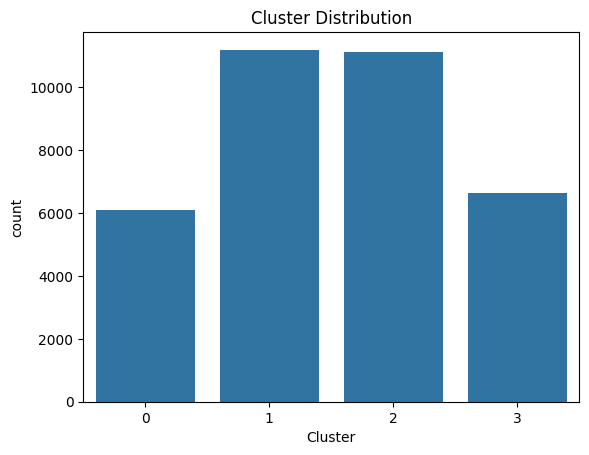

In [44]:


sns.countplot(x=merged_df["Cluster"])
plt.title("Cluster Distribution")
plt.show()


In [45]:
features = merged_df.drop(columns=["Cluster"])

# Normalize before PCA
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA (keep 80% variance)
pca = PCA(n_components=0.80)
X_pca = pca.fit_transform(features_scaled)

# Convert PCA results to a DataFrame
pca_columns = [f"PC{i+1}" for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, index=merged_df.index, columns=pca_columns)

# Add the Cluster column back
df_pca["Cluster"] = merged_df["Cluster"]


In [46]:

day_cluster_counts = merged_df.groupby(['day', 'Cluster']).size().unstack()
hour_cluster_counts = merged_df.groupby(['hour', 'Cluster']).size().unstack()
month_cluster_counts = merged_df.groupby(['month', 'Cluster']).size().unstack()

<Figure size 1200x500 with 0 Axes>

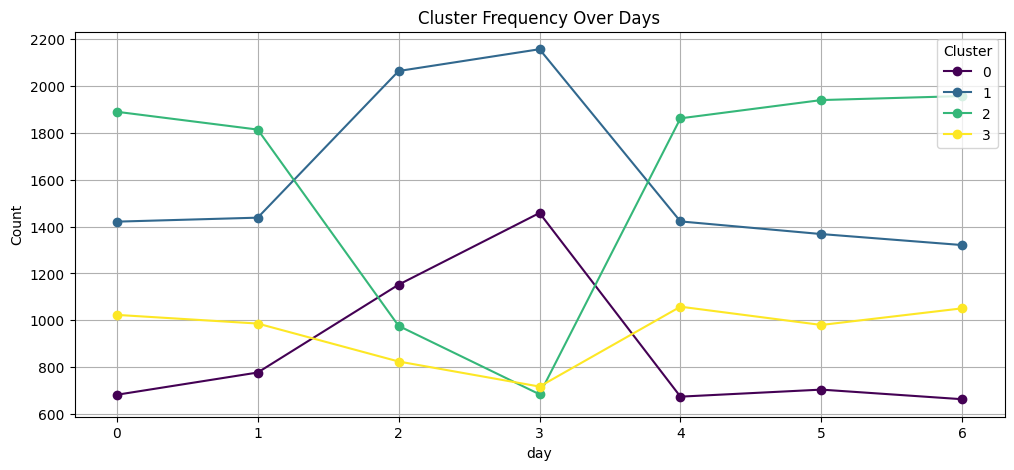

In [47]:
plt.figure(figsize=(12, 5))
day_cluster_counts.plot(kind='line', marker='o', figsize=(12, 5), cmap='viridis')
plt.title("Cluster Frequency Over Days")
plt.xlabel("day")
plt.ylabel("Count")
plt.legend(title="Cluster")
plt.grid()
plt.show()

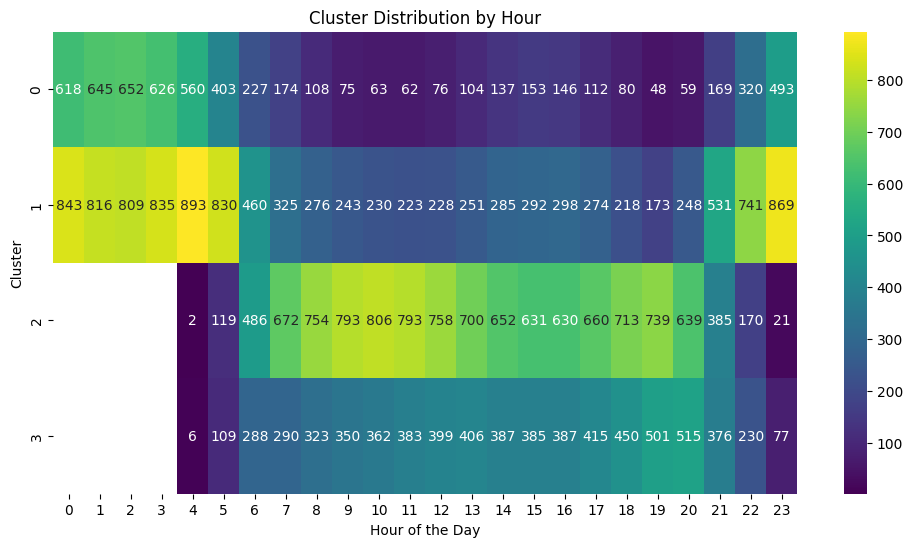

In [48]:
plt.figure(figsize=(12, 6))
sns.heatmap(hour_cluster_counts.T, cmap="viridis", annot=True, fmt=".0f")
plt.title("Cluster Distribution by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Cluster")
plt.show()

<Figure size 1000x400 with 0 Axes>

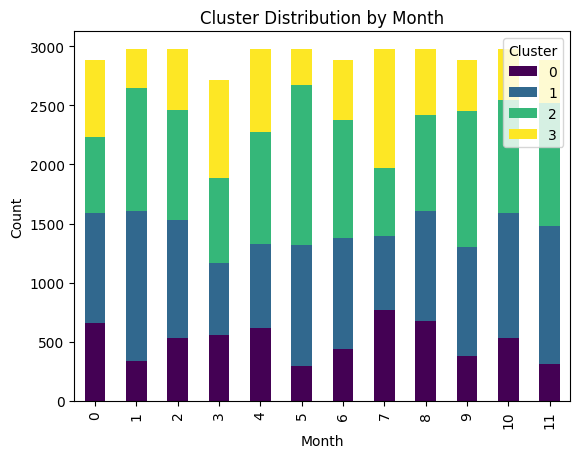

In [49]:
plt.figure(figsize=(10, 4))
month_cluster_counts.plot(kind="bar", stacked=True, colormap="viridis")
plt.title("Cluster Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend(title="Cluster")
plt.show()


## 📊 Key Observations from the Clustering Analysis  

### **1️⃣ Cluster Distribution Over Days**  
- The frequency of clusters changes depending on the day of the week.  
- Some clusters (e.g., Cluster 1 and Cluster 2) are more dominant on certain days, while others fluctuate.  
- This suggests that electricity price patterns follow a **weekly cycle**, making the **day of the week** an important factor.  

### **2️⃣ Cluster Distribution by Hour**  
- The heatmap shows that cluster frequencies vary significantly throughout the day.  
- Certain clusters (e.g., Cluster 1) peak in the early hours, while others are more frequent later in the day.  
- This indicates that electricity demand and pricing are strongly influenced by **hourly trends**, making **hour of the day** a useful feature.  

### **3️⃣ Cluster Distribution by Month**  
- The stacked bar chart shows how cluster proportions shift slightly across different months.  
- While monthly variations are not as strong as daily or hourly changes, they still suggest a **seasonal effect**.  
- This indicates that electricity pricing may be affected by seasonal factors such as **temperature, demand, or regulations**, making **month** a relevant feature.  

---

##  **Why Time Features Are Important**  
Since electricity prices and demand follow **daily, weekly, and seasonal patterns**, including **time-based features** like **day of the week, hour of the day, and month** can help capture these trends.  

Additionally, from the **Partial Autocorrelation Function (PACF) plot**, we observe a **strong 24-hour lag**, indicating that electricity prices are highly correlated with values from the previous day. This reinforces the importance of **both daily and hourly features** in forecasting models.  

By adding these features(which we already did this is a further proof), we allow our model to learn **patterns** in electricity prices based on time, improving forecasting accuracy.  


In [50]:
# encoder = LabelEncoder()

# # Fit and transform the 'day' column
# merged_df['day'] = encoder.fit_transform(merged_df['day'])
# merged_df['year'] = encoder.fit_transform(merged_df['year'])
# merged_df['month'] = encoder.fit_transform(merged_df['month'])
# merged_df['hour'] = encoder.fit_transform(merged_df['hour'])

# unwelcome_dtypes = [col for col in merged_df if merged_df[col].dtypes != 'float64' and merged_df[col].dtypes != 'int64']
# merged_df.drop(unwelcome_dtypes, axis=1, inplace=True)

##  Why Apply PCA?  

### **Reducing Dimensionality**  
Principal Component Analysis (**PCA**) helps reduce the number of features while preserving the most important information. This is especially useful when working with high-dimensional time-series data, as it simplifies the model and reduces computational cost.  

### **Handling Correlated and Redundant Features**  
As we observed earlier, there are **many correlated features** in our dataset, as well as features that are logically similar. PCA removes redundancy by transforming the data into a new set of uncorrelated features, capturing the most significant variance in the dataset.  

### **Making the Dataset Easier to Train On**  
By reducing the number of features while keeping the most relevant information, PCA makes the dataset **less complex and easier for models to learn from**. This can help improve training efficiency, reduce overfitting, and allow the model to generalize better to unseen data.  
  


In [51]:
# Define features (X) and target (y)
X = merged_df.drop(columns=['price actual']).values  # Exclude target variable
y = merged_df['price actual'].values.reshape(-1, 1)  # Reshape for scaler


# Split data into training & validation (80-20 split)
train_index = int(0.8 * len(X))
test_start_index = train_index 

#  Initialize scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit and Transform Training Data
X_scaled_train = scaler_X.fit_transform(X[:train_index])
y_scaled_train = scaler_y.fit_transform(y[:train_index])


#  Transform Validation Data using the SAME Scaler
X_scaled_val = scaler_X.transform(X[train_index:])
y_scaled_val = scaler_y.transform(y[train_index:])

#  Apply PCA (Fit on Training, Transform Both Train & Validation)
pca = PCA(n_components=0.80)  # Keep 80% variance
X_pca_train = pca.fit_transform(X_scaled_train)  # Fit PCA on training data
X_pca_val = pca.transform(X_scaled_val)  # Apply same PCA to validation, importan to fit only the X_train


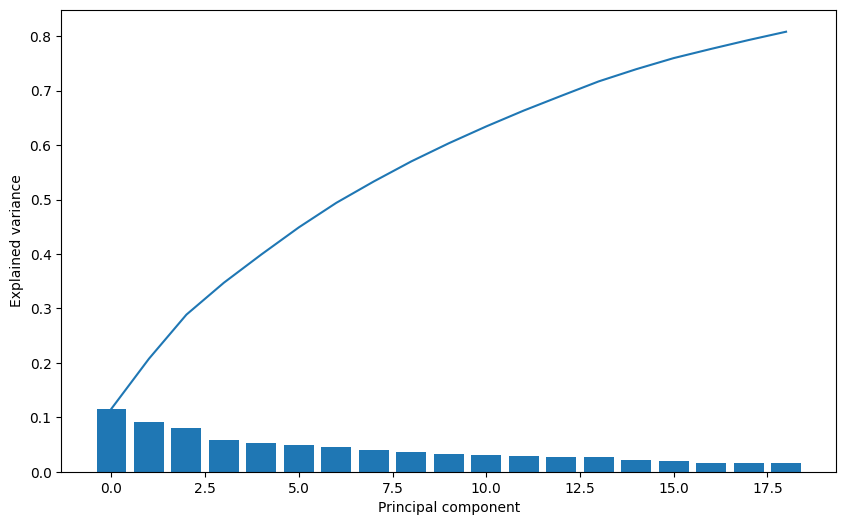

In [52]:
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()



This graph shows how much variance each **Principal Component (PC)** captures in the dataset.  

### **Bar Chart (Blue Bars) - Individual Variance Contribution**  
- Each bar represents a **single principal component** and the amount of variance it explains.  
- The first few components capture the most variance, while later components contribute less.  

### **Line Plot (Cumulative Variance)**  
- The line represents the **cumulative sum** of explained variance.  
- It shows how much total variance is retained as we add more components.  
- From the curve, we see that a small number of components capture most of the variance, meaning **dimensionality reduction is effective**.  

### **Key Insights**  
✔ The **first few components** retain most of the information, confirming that many original features were redundant or highly correlated.  
✔ We can **reduce dimensionality** while keeping around **80% of the variance**, making the dataset smaller and easier to train on without losing much information.  
✔ This validates the use of PCA for feature reduction before modeling. 


### Forecasting Stage

We are now getting into the forecasting stage, where we aim to predict future electricity prices,


In this initial step, we will use a subset of features, such as various forms of energy generation, total load, and day-ahead prices, to observe the model's performance and validate its setup. After gaining insights from these initial results, we will expand to include all available features for a more comprehensive evaluation.

We will have the training from 2015-01-01 to 2018-06-301, and the test period will be from 2018-07-01 to 2018-12-31. 80%-20% as it common to do.        

In [53]:
# Ensure the index is in datetime format
merged_df.index = pd.to_datetime(merged_df.index)
# Set the frequency of the index to hourly
merged_df = merged_df.asfreq('h')
# Define train and test periods
tr_start, tr_end = '2015-01-01', '2018-06-30'
te_start, te_end = '2018-07-01', '2018-12-31'

# Select the training and testing data based on the date ranges
train_data = merged_df['price actual'][tr_start:tr_end]
exog_train = merged_df[['generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead']][tr_start:tr_end]
exog_test = merged_df[['generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead']][te_start:te_end]
test_data = merged_df['price actual'][te_start:te_end]

# Re-align the exogenous data to match the train data index
exog_train = exog_train.loc[train_data.index]

### SARIMAX Model Fit

In this section, we fit the SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) model on our training data. SARIMAX is one of the most classic and widely used time-series forecasting algorithms due to its ability to model both seasonal and non-seasonal patterns, while also incorporating external variables (exogenous features) that can influence the target variable. This makes it highly suitable for forecasting problems where both historical dependencies and external factors play a role.

#### Why Seasonal Order of (2, 0, 0, 25)?

Based on the insights from the PACF plot, we observed that the autocorrelation between an observation at a given hour and its lagged values is strongest for lags up to 25. This suggests a seasonal pattern with a period of 24 hours, which makes sense for this dataset since it involves hourly data. A lag of 25 captures this daily seasonality, representing the pattern that repeats every 24 hours, plus an additional lag for seasonal nuances.

Therefore, we choose the seasonal order `(2, 0, 0, 25)` to incorporate this observed seasonal structure, where:
- The `2` indicates the number of seasonal autoregressive (AR) terms (based on PACF findings),
- The `0` indicates no differencing for seasonality,
- The `25` represents the length of the seasonal period (24 hours + 1).

#### Why (2, 0, 0) for the Non-Seasonal Order?

The choice of `(2, 0, 0)` for the non-seasonal ARIMA components is based on the PACF plot, where we saw significant spikes at the first two lags. The PACF suggests that only the first two lags of the time series are significant for the autoregressive (AR) part of the model, and we chose a non-seasonal order with `p=2` to capture these dependencies.

This configuration allows the model to capture both the short-term dependencies (from the non-seasonal AR) and the daily seasonal patterns (from the seasonal AR) effectively.

#### Model Fitting

We use `maxiter=500` to allow the model to iterate up to 500 times. The `parallel=True` argument leverages multiple cores to speed up the fitting process. By setting `disp=False`, we suppress the output during the fitting process to keep it clean and focused.



In [54]:

# Fit the SARIMAX model
model = sm.tsa.SARIMAX(train_data, exog=exog_train,maxiter=500, order=(2, 0, 0), seasonal_order=(2, 0, 0, 25))
model_fit = model.fit(disp=False, parallel=True)


/Users/nirdagan/anaconda3/envs/new_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/nirdagan/anaconda3/envs/new_env/lib/python3.11/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: parallel. After release 0.14, this will raise.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
 # Save the model using the built-in save method:
model_fit.save('sarimax_model.pkl')

In [ ]:
import os
import statsmodels.api as sm

# Define model filename
model_filename = 'sarimax_model.pkl'

if os.path.exists(model_filename):
    # Load existing model
    from statsmodels.tsa.statespace.sarimax import SARIMAXResults
    model_fit = SARIMAXResults.load(model_filename)
    print("✅ Loaded existing SARIMAX model from file.")
else:
    # Fit the model since it doesn't exist
    print("⚙️ No existing model found. Fitting a new SARIMAX model...")
    model = sm.tsa.SARIMAX(train_data, 
                           exog=exog_train, 
                           maxiter=500, 
                           order=(2, 0, 0), 
                           seasonal_order=(2, 0, 0, 25))
    model_fit = model.fit(disp=False, parallel=True)

    # Save the model
    model_fit.save(model_filename)
    print("✅ Model trained and saved successfully.")


⚙️ No existing model found. Fitting a new SARIMAX model...


/Users/nirdagan/anaconda3/envs/datascience_project/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/nirdagan/anaconda3/envs/datascience_project/lib/python3.11/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: parallel. After release 0.14, this will raise.
  warnings.warn(


KeyboardInterrupt: 

### RMSE (Root Mean Squared Error)  

To evaluate the performance of our forecasting models, we will use **RMSE (Root Mean Squared Error)**, which is a commonly used metric for regression and time-series prediction tasks. RMSE measures the **average magnitude of the errors** between the actual and predicted values, with a lower RMSE indicating better predictive accuracy.  

The formula for RMSE is:  
$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$  

### **Interpreting RMSE in Our Forecasting Task**  
- Our target variable is **actual electricity price**, measured in **EUR/MWh** (Euros per Megawatt-hour).  
- **For example, if RMSE = 8**, it means that, on average, the predicted electricity price deviates by **8 EUR/MWh from the actual price**.  
- If the average electricity price is around **50 EUR/MWh**, an RMSE of **8 EUR/MWh** represents a significant error, whereas if prices fluctuate around **200 EUR/MWh**, the same RMSE would be relatively smaller in proportion to the price scale.  
- A **lower RMSE** indicates more accurate predictions, which is critical for energy market forecasting where even small deviations can impact financial decisions.  


In [61]:
def calculate_rmse(actual, predicted):
    # Ensure that the inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    
    return rmse

In [381]:
# Generate predictions for the test set
start = len(train_data)  # Start from the end of the training set
end = start + len(test_data) - 1  # End at the length of the test set
predictions = model_fit.predict(start=start, end=end, exog=exog_test)

# Calculate RMSE
rmse = calculate_rmse(test_data, predictions)
print(f"Root Mean Square Error (RMSE): {rmse}")
print(test_data['actual_price'].mean())

ValueError: Provided exogenous values are not of the appropriate shape. Required (4415, 10), got (4415, 67).

In [385]:
print(test_data.mean())

69.82916194790486


### RMSE Evaluation: Understanding the Model's Performance

The **Root Mean Squared Error (RMSE)** we obtained is **20**, while the **mean actual electricity price** is **60 EUR/MWh**. This means that, on average, our predictions deviate from the actual values by about **one-third of the typical price level**.

Such a high RMSE relative to the target’s mean suggests that the model struggles to capture key patterns in the data. A more accurate model should have an RMSE significantly lower than the mean price to ensure reliable forecasts.
we will see it in the visualization bellow

### Forecasting the Next 100 Hours with the SARIMAX Model

Here we define the forecast period to predict the next 100 hours of electricity price data using the fitted SARIMAX model

- **Forecast Period:** We create a `pd.date_range` to define the next 100 hours after the test data ended.
- **Exogenous Variables:** We extract the relevant features from the merged dataset, such as generation data and load information, and align them with the forecast period.
- **Forecasting:** The `forecast` method of the fitted model is then used to generate predictions for the next 100 hours, using the prepared exogenous variables.

We then visualize the forecasted results:

- **Plotting:** The plot displays both the test data for the initial 100 hours and the predictions for the next 100 hours. The predicted values are shown as a dashed line, while the test data is plotted as a solid line.


/Users/nirdagan/anaconda3/envs/datascience_project/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


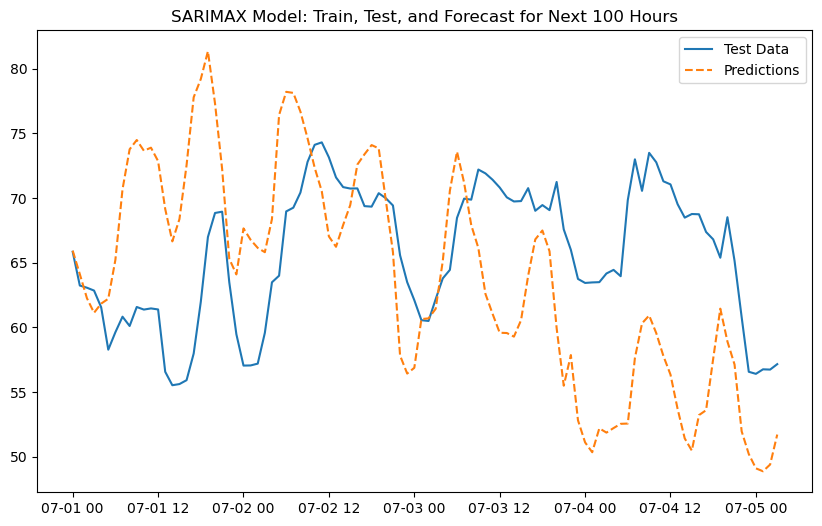

In [ ]:
# Define the forecast period (next 100 hours)
forecast_period = pd.date_range(start=test_data.index[0], periods=100, freq='H')

# get the exogenous variables for the forecast period
exog_forecast = merged_df[['generation hydro run-of-river and poundage',
                           'generation hydro water reservoir', 'generation nuclear',
                           'generation other', 'generation other renewable', 'generation solar',
                           'generation waste', 'generation wind onshore', 'total load actual',
                           'price day ahead']].reindex(forecast_period)



# Make the forecast
predictions = model_fit.forecast(steps=100, exog=exog_forecast)
# Create a time index for the next 100 hours
last_time = test_data.index[-1]  # The last timestamp in your test data
forecast_index = pd.date_range(start=last_time, periods=25, freq='H')[1:]  # 100 hours after the last timestamp
test_100_first_hours = test_data[:100]
forecast_index = test_100_first_hours.index
# Convert the forecast to a DataFrame with the new index
predictions_df = pd.DataFrame(predictions, index=forecast_index, columns=['predicted_mean'])
test_100_first_hours = test_data[:100]
# Plot the train and test data
plt.figure(figsize=(10,6))

# Plot the test data (up to the end of the test period)
plt.plot(predictions_df.index, test_100_first_hours, label='Test Data')

# Plot only the predictions for the next 100 hours
plt.plot(predictions_df.index, predictions_df['predicted_mean'], label='Predictions', linestyle='--')

# Add the legend and title
plt.legend()
plt.title('SARIMAX Model: Train, Test, and Forecast for Next 100 Hours')

# Display the plot
plt.show()

We can observe that the prediction closely follows the actual data, with a slight shift. The trends, as well as the peaks and troughs, are predicted quite well. However, there seems to be a downward shift in the forecasted values for some reason, which could be worth investigating further.

Another reason why the forecast performs worse at the beginning compared to the middle is that July 1, 2018, falls on a Sunday. The model may struggle more with weekend predictions, as electricity price patterns can differ significantly from weekdays. This is evident from the actual price being lower than the predicted price, which aligns with typical weekend trends.

In [370]:

# Select the training and testing data based on the date ranges
train_data = merged_df['price actual'][tr_start:tr_end]
all_cols_besides_price = [col for col in merged_df.columns if col != 'price actual']
exog_train = merged_df[all_cols_besides_price][tr_start:tr_end]
exog_test = merged_df[all_cols_besides_price][te_start:te_end]
test_data = merged_df['price actual'][te_start:te_end]



Now we will use the same SARIMAX with the same parameters but with all the features, not just a subset.

In [371]:
alL_features_model = sm.tsa.SARIMAX(train_data, exog=exog_train,maxiter=500, order=(2, 0, 0), seasonal_order=(2, 0, 0, 25))

alL_features_model_fit = alL_features_model.fit()

/Users/nirdagan/anaconda3/envs/datascience_project/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           72     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73896D+00    |proj g|=  1.70132D+01

At iterate    5    f=  2.71273D+00    |proj g|=  6.88271D+00

At iterate   10    f=  2.69955D+00    |proj g|=  2.98271D+00

At iterate   15    f=  2.69731D+00    |proj g|=  2.31509D+00

At iterate   20    f=  2.69391D+00    |proj g|=  2.21185D+00

At iterate   25    f=  2.67853D+00    |proj g|=  2.03060D+01

At iterate   30    f=  2.66702D+00    |proj g|=  2.18212D+00

At iterate   35    f=  2.65433D+00    |proj g|=  2.47012D+00

At iterate   40    f=  2.64257D+00    |proj g|=  1.45427D+01

At iterate   45    f=  2.63636D+00    |proj g|=  4.83754D+00

At iterate   50    f=  2.63385D+00    |proj g|=  3.15334D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/nirdagan/anaconda3/envs/datascience_project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [380]:
alL_features_model_fit.save('/tmp/sarimax_model.pkl')

 # Save the model using the built-in s

OSError: [Errno 28] No space left on device

In [377]:
# Generate predictions for the test set
start = len(train_data)  # Start from the end of the training set
end = start + len(test_data) - 1  # End at the length of the test set
predictions = alL_features_model_fit.predict(start=start, end=end, exog=exog_test)

# Calculate RMSE
rmse = calculate_rmse(test_data, predictions)
print(f"Root Mean Square Error (RMSE): {rmse}")


Root Mean Square Error (RMSE): 10.0478183850115


As we can see we got a better results, but like we expected the running time is a alot longer.

/Users/nirdagan/anaconda3/envs/datascience_project/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


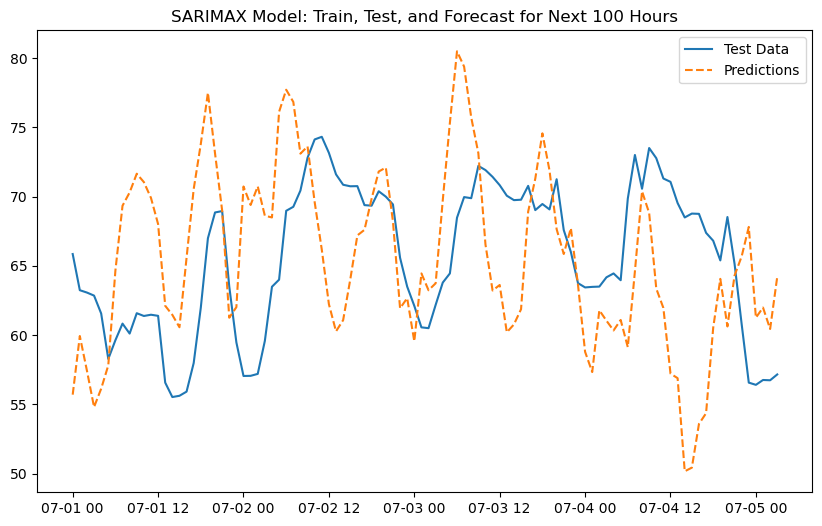

In [607]:

exog_forecast = merged_df[all_cols_besides_price].reindex(forecast_period)

# Make the forecast
predictions = alL_features_model_fit.forecast(steps=100, exog=exog_forecast)
# Create a time index for the next 100 hours
last_time = test_data.index[-1]  # The last timestamp in your test data
forecast_index = pd.date_range(start=last_time, periods=25, freq='H')[1:]  # 100 hours after the last timestamp
test_100_first_hours = test_data[:100]
forecast_index = test_100_first_hours.index
# Convert the forecast to a DataFrame with the new index
predictions_df = pd.DataFrame(predictions, index=forecast_index, columns=['predicted_mean'])
test_100_first_hours = test_data[:100]

# Plot the train and test data
plt.figure(figsize=(10,6))

# Plot the test data (up to the end of the test period)
plt.plot(predictions_df.index, test_100_first_hours, label='Test Data')

# Plot only the predictions for the next 100 hours
plt.plot(predictions_df.index, predictions_df['predicted_mean'], label='Predictions', linestyle='--')

# Add the legend and title
plt.legend()
plt.title('SARIMAX Model: Train, Test, and Forecast for Next 100 Hours')

# Display the plot
plt.show()

It looks like in the first few days, we have a really good forecast, but after that, the predicted line shifts slightly. The trend and patterns are similar, but there's a noticeable shift in the forecast. This behavior is common for models like this, as it's generally easier for them to predict short-term data but harder to make accurate forecasts for the "far" future.

Next Model - Prophet
## Forecasting with Prophet 📈

**Prophet** is an open-source forecasting tool developed by Facebook (Meta) in **2017**. It is widely used for **time-series forecasting** and is well-known for its ability to model **seasonality, trends, and holidays** with minimal tuning. Prophet is designed to be intuitive, flexible, and robust against missing data and outliers.

###  How Does Prophet Work?
Prophet models a time series using three main components:
1. **Trend**: Captures long-term increases or decreases in the data.
2. **Seasonality**: Accounts for repeating patterns (daily, weekly, yearly).
3. **Holidays/Events**: Adjusts for known special events that impact the series.

### How Does Prophet Work Technically?
Prophet is based on an **additive regression model**, which combines these components:

- **Generalized Additive Models (GAMs)**: Prophet uses GAMs instead of traditional deep learning or classic ARIMA models. It fits piecewise linear trends with change points to capture shifts in growth.
- **Fourier Series for Seasonality**: It represents seasonal effects using Fourier series, making it flexible for capturing complex periodic patterns.
- **Bayesian Change Point Detection**: Prophet automatically detects change points in trend and adjusts accordingly.


in the cell bellow we will do PCA again(just for convinet) for the Prophet model.

In [55]:
merged_df.index = pd.to_datetime(merged_df.index).tz_localize(None)

exog_data = merged_df.drop(columns=['price actual'])

# Scale the exogenous data
scaler_exog = MinMaxScaler(feature_range=(0, 1))
exog_scaled = scaler_exog.fit_transform(exog_data)

# Apply PCA to capture 80% of the variance
pca = PCA(n_components=0.80)
exog_pca = pca.fit_transform(exog_scaled)
# Create a DataFrame for the PCA components
num_components = exog_pca.shape[1]
pc_columns = [f'PC{i+1}' for i in range(num_components)]
exog_pca_df = pd.DataFrame(exog_pca, index=merged_df.index, columns=pc_columns)


We will prepare the data for the prohet - 

Prophet requires a **'ds'** column for timestamps and a **'y'** column for the target. We reset the index to ensure the datetime column is named **'ds'** and rename **'price actual'** to **'y'**. Exogenous PCA components are included as additional features to enhance forecasting. 

In [57]:

# Set the index name so that reset_index creates a 'ds' column
merged_df.index.name = 'ds'

# Join the target column with the PCA components
df_prophet = merged_df[['price actual']].join(exog_pca_df)

# Reset index so that the datetime becomes a column named 'ds'
# Rename the target column to 'y' as required by Prophet
df_prophet = df_prophet.reset_index().rename(columns={'price actual': 'y'})

print("Columns in df_prophet:", df_prophet.columns)  # Should include 'ds', 'y', 'PC1', 'PC2', etc.


Columns in df_prophet: Index(['ds', 'y', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8',
       'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17',
       'PC18', 'PC19'],
      dtype='object')


 Continue with Train/Test Split

In [58]:

tr_start, tr_end = '2015-01-01', '2018-06-30'
te_start, te_end = '2018-07-01', '2018-12-31'

df_train = df_prophet[(df_prophet['ds'] >= tr_start) & (df_prophet['ds'] <= tr_end)]
df_test  = df_prophet[(df_prophet['ds'] >= te_start) & (df_prophet['ds'] <= te_end)]


We now train the **Prophet** model to forecast electricity prices, using **seasonality, holidays, and external regressors** (PCA components). RMSE measures accuracy, while plots reveal trends and seasonal patterns.

Prophet's `add_country_holidays` is used to incorporate **Spain's holidays**, and we enable **yearly, weekly, and daily seasonality** based on the known seasonal patterns in the data.  


In [59]:


# Initialize Prophet
prophet_model = Prophet(
    seasonality_mode='additive',
    changepoint_prior_scale=0.05,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True
)

prophet_model.add_country_holidays(country_name='ES')

# Add each PCA component as a regressor
for pc in pc_columns:
    prophet_model.add_regressor(pc)

# Fit the model
prophet_model.fit(df_train)

# Prepare future DataFrame
future = df_test[['ds'] + pc_columns].copy()

# Generate forecast
forecast = prophet_model.predict(future)

10:59:56 - cmdstanpy - INFO - Chain [1] start processing
11:00:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error (RMSE): 9.84


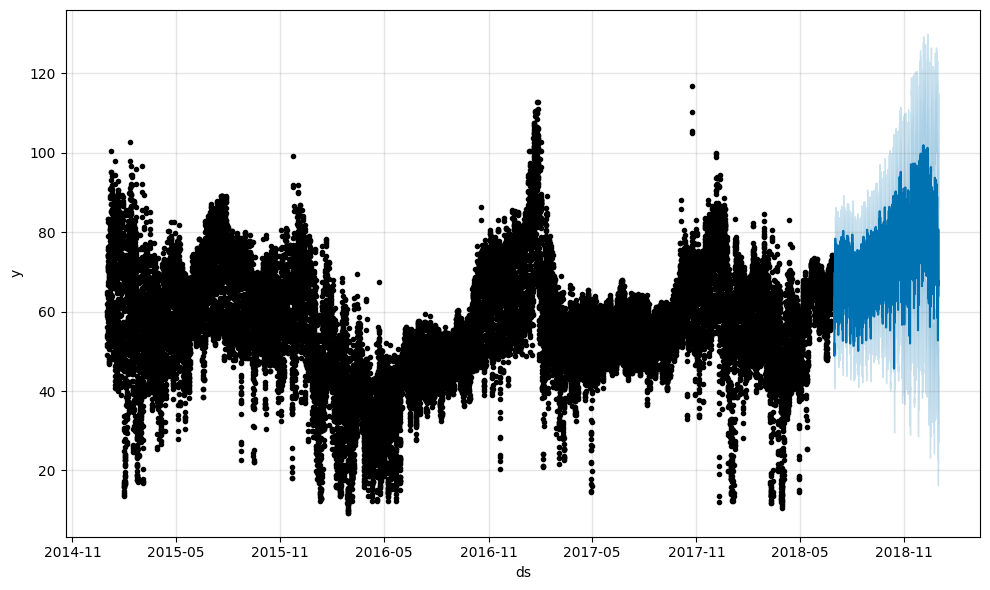

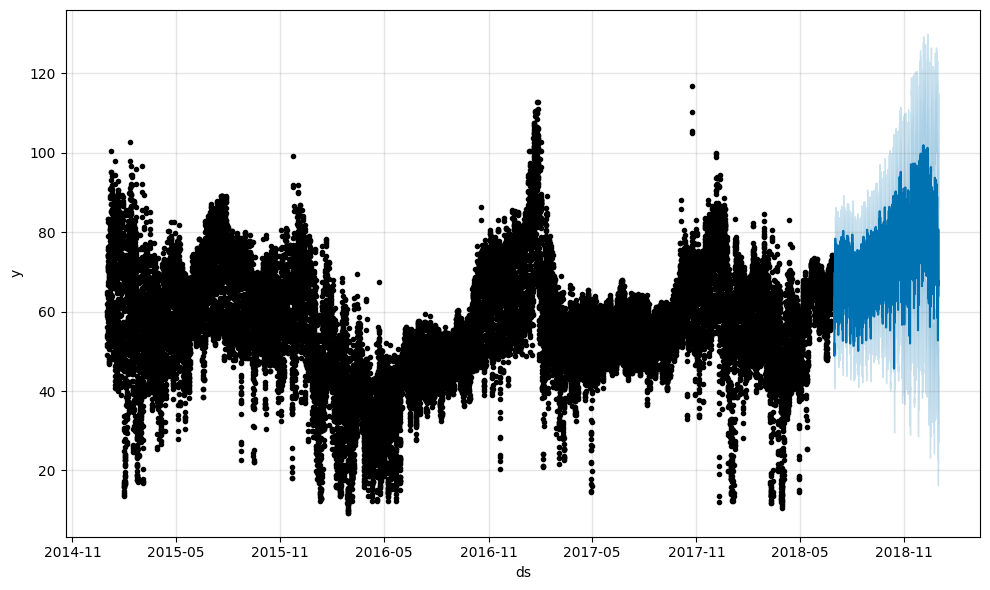

In [62]:

# Merge forecasted values with the true target
forecasted_values = forecast[['ds', 'yhat']].set_index('ds')
results = df_test.set_index('ds')[['y']].merge(forecasted_values, left_index=True, right_index=True)


rmse = calculate_rmse(results['y'], results['yhat'])
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot the forecast and its components
prophet_model.plot(forecast)
# prophet_model.plot_components(forecast)

## Evaluation of Prophet Forecasting

Our Prophet model achieved an RMSE of **9 EUR/MWh**, which means the predictions deviate from the actual electricity price by about 9 EUR/MWh on average. Given that the mean actual price is around **60 EUR/MWh**, this error is moderate. 

While not the lowest possible error, this performance is comparable to what we obtained with the Samira model, and Prophet offers the advantage of **faster running times**. This efficiency makes Prophet an attractive option for our forecasting needs.


now we will try to forecast only the 100 hours, and will visualize it for comparsion with the other models

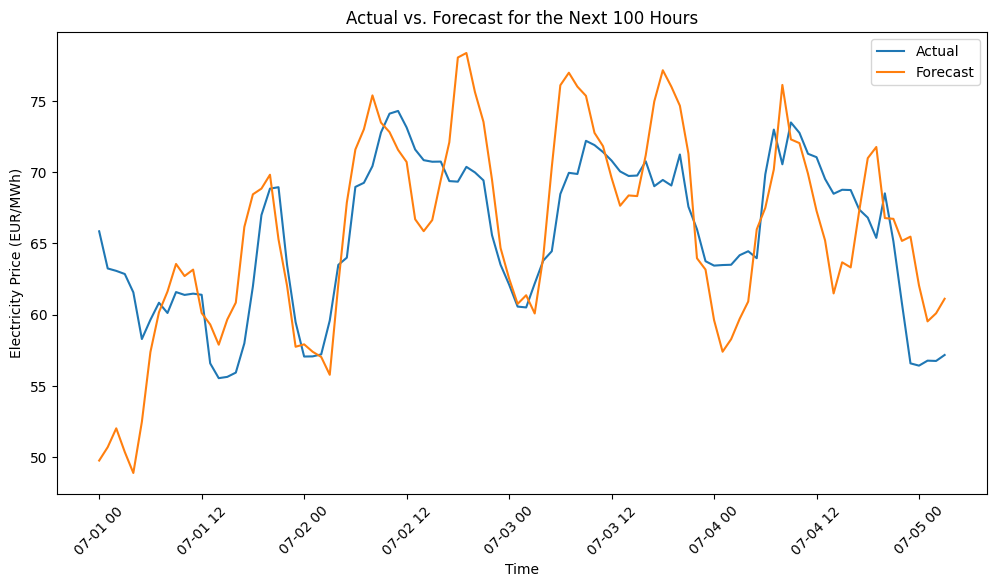

In [63]:
# 1. Subset the test data to 100 hours
df_test_100 = df_test.head(100).copy()

# 2. Prepare the future DataFrame (with 'ds' and PCA columns)
future_100 = df_test_100[['ds'] + pc_columns].copy()

# 3. Generate the forecast for only 100 hours
forecast_100 = prophet_model.predict(future_100)

# Merge forecast with actual target values
forecasted_values_100 = forecast_100[['ds', 'yhat']].set_index('ds')
results_100 = df_test_100.set_index('ds')[['y']].merge(forecasted_values_100, left_index=True, right_index=True)

# Plot actual vs. forecast
plt.figure(figsize=(12, 6))
plt.plot(results_100.index, results_100['y'], label='Actual')
plt.plot(results_100.index, results_100['yhat'], label='Forecast')
plt.xlabel('Time')
plt.ylabel('Electricity Price (EUR/MWh)')
plt.title('Actual vs. Forecast for the Next 100 Hours')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### 100-Hour Forecast Insights

Over this **100-hour forecast**, the model performs **reasonably well** overall, with a tighter match between actual and predicted prices **mid-week**. However, the **weekend segment** around July 7th exhibits larger deviations—similar to our findings with the Samira model—indicating that **weekend patterns** remain challenging to predict accurately. This suggests that additional weekend-specific features or model tuning may be necessary to capture these **distinct consumption behaviors**.  


## AutoARIMAProphet Model

The **AutoARIMAProphet** model is a hybrid approach that combines ARIMA's robust statistical time-series modeling with Prophet's ability to capture seasonality and holiday effects. This model, which I received from Idan and is part of the [Nixtla statsforecast experiments](https://github.com/Nixtla/statsforecast/tree/main/experiments/arima_prophet_adapter), automatically tunes ARIMA parameters while leveraging Prophet’s components for capturing yearly, weekly, and holiday patterns.

Key features include:
- **Automatic Parameter Selection**: Finds the best ARIMA configuration for the data.
- **Seasonality and Holiday Handling**: Integrates additive (or multiplicative) seasonality along with country-specific holiday effects.
- **Exogenous Regressors**: Supports additional predictors (like our PCA components) to further enhance forecasting accuracy.

We will now compare the performance of AutoARIMAProphet with the other models used in our analysis.


In [73]:
# Define training and testing date ranges
tr_start, tr_end = '2015-01-01', '2018-06-30'
te_start, te_end = '2018-07-01', '2018-12-31'

# Split the DataFrame into training and testing sets (including the PCA regressors)
df_train_exog = df_prophet[(df_prophet['ds'] >= tr_start) & (df_prophet['ds'] <= tr_end)]
df_test_exog  = df_prophet[(df_prophet['ds'] >= te_start) & (df_prophet['ds'] <= te_end)]

# Identify the PCA columns (assumed to start with 'PC')
pc_columns = [col for col in df_prophet.columns if col.startswith('PC')]


model_filename = "autoarima_prophet_model.pkl"

if os.path.exists(model_filename):
    print("Saved model found. Loading model...")
    with open(model_filename, "rb") as f:
        prophet_arima_model = pickle.load(f)
else:
    print("No saved model found. Training model...")
    # Initialize AutoARIMAProphet and add regressors
    prophet_arima_model = AutoARIMAProphet(
        seasonality_mode='additive',         # or 'multiplicative'
        changepoint_prior_scale=0.05,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False
    )
    # Add each PCA component as an exogenous regressor
    for col in pc_columns:
        prophet_arima_model.add_regressor(col)
    
    # Fit the model on the training data
    prophet_arima_model.fit(df_train_exog)
    
    # Save the trained model using pickle
    with open(model_filename, "wb") as f:
        pickle.dump(prophet_arima_model, f)
    print("Model trained and saved.")

# Prepare future DataFrame for prediction (remove the target column 'y')
future = df_test_exog.drop(columns=['y'])

# Generate forecast using the loaded or trained model
forecast = prophet_arima_model.predict(future)


Saved model found. Loading model...


New RMSE: 8.36


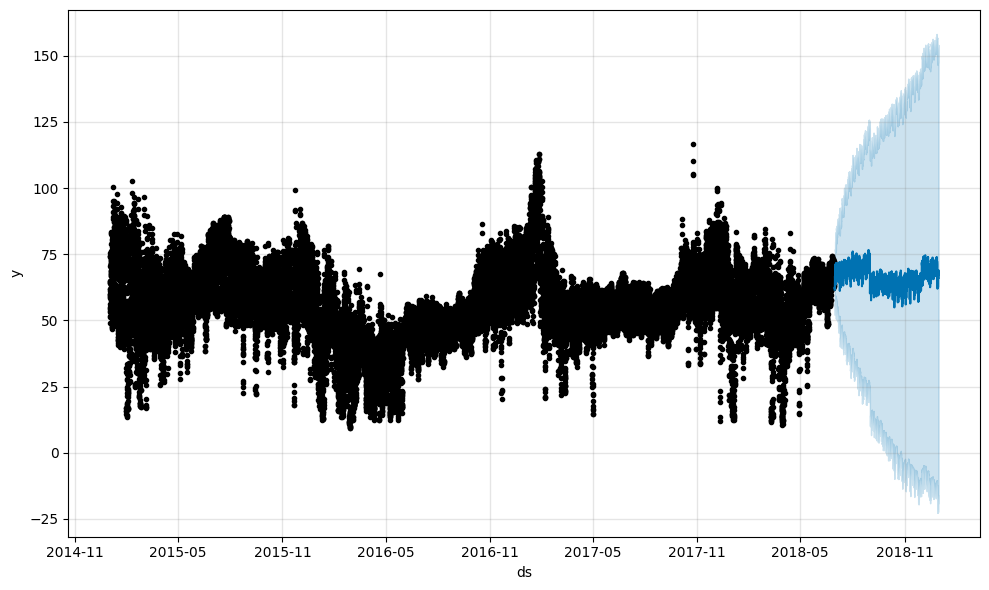

In [75]:
# ---------------------------------------------
# Evaluate the model performance
# ---------------------------------------------
# Merge the forecast with the true test target values
forecasted_values = forecast[['ds', 'yhat']].set_index('ds')
results = df_test_exog.set_index('ds')[['y']].merge(forecasted_values, left_index=True, right_index=True)

rmse = calculate_rmse(results['y'], results['yhat'])

print(f"New RMSE: {rmse:.2f}")

# ---------------------------------------------
# Plot the forecast
# ---------------------------------------------
model.plot(forecast)
plt.show()

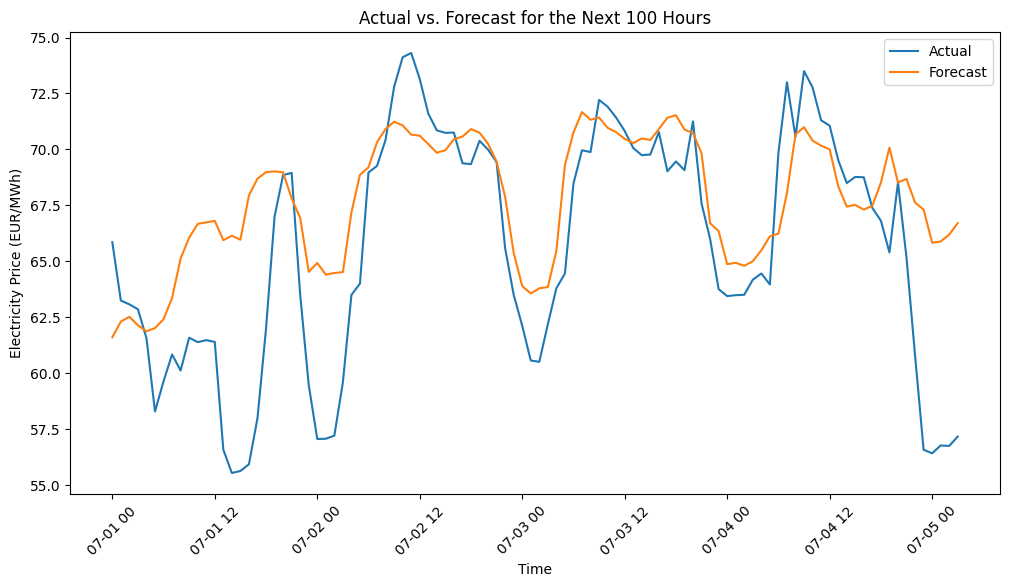

In [74]:
# Generate forecast for the next 100 hours using the AutoARIMAProphet model
forecast_100 = prophet_arima_model.predict(future_100)

# Merge forecast with actual target values
forecasted_values_100 = forecast_100[['ds', 'yhat']].set_index('ds')
results_100 = df_test_100.set_index('ds')[['y']].merge(forecasted_values_100, left_index=True, right_index=True)

# Plot actual vs. forecast
plt.figure(figsize=(12, 6))
plt.plot(results_100.index, results_100['y'], label='Actual')
plt.plot(results_100.index, results_100['yhat'], label='Forecast')
plt.xlabel('Time')
plt.ylabel('Electricity Price (EUR/MWh)')
plt.title('Actual vs. Forecast for the Next 100 Hours')
plt.legend()
plt.xticks(rotation=45)
plt.show()

As shown in the graph, AutoARIMAProphet achieves a slightly better RMSE (around 8 EUR/MWh) compared to 9 with Prophet and 10 with Samira. However, the model still struggles on weekends, as seen around 07-01, and fails to capture the sharp jump near the end of the forecast period that other models predict more accurately. While short-term performance is improved overall, these results highlight the challenges of weekend patterns and sudden price changes for all models.

# Predicting Electricity Prices with LSTM

Before training our LSTM model, we need to define helper functions and perform data preprocessing. This includes creating time-series sequences, scaling features, and applying PCA for dimensionality reduction. These steps ensure our data is properly formatted and optimized for the LSTM model.


###  Define the Data Preparation Function


In [76]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    """
    Creates sequences of features (data) and labels (target) for time-series modeling.
    
    Args:
        dataset (np.array): Feature array with shape [samples, features].
        target (np.array):  Target array (e.g., price) with shape [samples,].
        start_index (int):  Starting index for data slicing.
        end_index (int):    Ending index for data slicing.
        history_size (int): Number of past time steps to include in each sequence.
        target_size (int):  Number of future steps to predict.
        step (int):         Step size between points in the history window.
        single_step (bool): If True, predict only one step ahead; otherwise, multi-step.
    
    Returns:
        data (np.array):   Shape [num_sequences, history_size/step, features].
        labels (np.array): Shape [num_sequences, target_size or 1].
    """
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)


###  Load and Scale Data, Apply PCA, and Create Datasets

In [77]:
train_end_idx = 27048
cv_end_idx = 31055
test_end_idx = 35063

# Separate features (X) and target (y)
X = merged_df[merged_df.columns.drop('price actual')].values
y = merged_df['price actual'].values.reshape(-1, 1)

# Scale features and target using MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

# Apply PCA to retain 80% variance
pca = PCA(n_components=0.80)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

# Combine PCA-transformed features with scaled target
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

# Define history (past steps) and future target (0 for single-step)
past_history = 24
future_target = 0

# Create train, validation, and test sets
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=True)
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)


###  Prepare TensorFlow Datasets and Define Model


In [78]:
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

### LSTM Model for Time-Series Forecasting

**Long Short-Term Memory (LSTM)** networks are a specialized type of recurrent neural network (RNN) that excel at capturing long-range dependencies in sequential data. This makes them particularly effective for time-series forecasting, as they can process entire sequences and retain information over long periods.

Due to our long-term sequence of observations, LSTMs can effectively identify trends, seasonal patterns, and cyclical behaviors in the data. This capability allows them to capture daily, weekly, and yearly seasonality more robustly than standard RNNs, which often struggle with issues like the vanishing gradient problem.


#### **Model Architecture**
1. **LSTM Layer** (`100` units, `return_sequences=True`): Learns temporal patterns from the past 24 time steps.
2. **Flatten Layer**: Converts the 2D output of the LSTM into a 1D vector.
3. **Dense Layer** (`200` units, ReLU activation): Introduces non-linearity and learns more complex relationships.
4. **Dropout Layer** (`0.1`): Reduces overfitting by randomly deactivating neurons during training.
5. **Output Layer** (`1` unit): Produces the final predicted value.

#### **Training Optimizations**
- **Adam Optimizer**: A popular optimization algorithm that adapts learning rates for each parameter, speeding up convergence and improving performance.
- **Early Stopping**: Monitors validation loss and stops training if no improvement is observed, preventing overfitting and saving computational resources.

This setup balances **model complexity** with **regularization** (via dropout and early stopping) to achieve stable, accurate time-series predictions.  


In [89]:
batch_size = 32
buffer_size = 1000

# Convert NumPy arrays to TensorFlow datasets
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

# Reshape y_test for inverse scaling later
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

# Common parameters
input_shape = X_train.shape[-2:]  # (24, num_features)
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Learning rate schedule (optional)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 10))

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

# Clear any previous model
tf.keras.backend.clear_session()

# Build LSTM model
lstm_only = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

# Compile
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'lstm_only.h5', monitor=('val_loss'), save_best_only=True)

optimizer = Adam(learning_rate=6e-3, amsgrad=True)
lstm_only.compile(loss=loss, optimizer=optimizer, metrics=metric)

/Users/nirdagan/anaconda3/envs/new_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model Loading and Training

Before starting the training process, we first check if a saved model file (`ltsm_only.h5`) already exists. If it does, we load this model and skip retraining. Otherwise, we proceed to train the model using the training and validation datasets. This approach saves time and computational resources by avoiding unnecessary re-training.


In [93]:
import os

# Check if a saved model exists
model_filepath = "lstm_only.h5"
if os.path.exists(model_filepath):
    print("Saved model found. Loading model in the next cell instead of training.")

else:
    # Train the model if no saved model exists
    history = lstm_only.fit(
        train,
        epochs=120,
        validation_data=validation,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )


Saved model found. Loading model in the next cell instead of training.


In [96]:
# Load the pre-trained LSTM model
lstm_model = tf.keras.models.load_model('lstm_only.h5')

# Generate predictions on the test set (predictions are scaled)
scaled_predictions = lstm_model.predict(X_test)

# Convert scaled predictions back to original scale (EUR/MWh)
predictions = scaler_y.inverse_transform(scaled_predictions)

# Calculate the RMSE between the true values and predictions
lstm_rmse = calculate_rmse(y_test_inv, predictions)
print('RMSE of LSTM forecast: {}'.format(round(lstm_rmse, 3)))


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
RMSE of LSTM forecast: 2.632


### Evaluation of LSTM Forecast Results

Our LSTM-based neural network achieved an **RMSE of 2.632 EUR/MWh**, which is a significant improvement over our previous models (Samira and Prophet, with RMSE values around 9–10). 

**What does an RMSE of 2.632 mean?**  
An RMSE of 2.632 implies that, on average, the predictions deviate from the actual prices by only 2.632 EUR/MWh. Given that the mean electricity price is about 60 EUR/MWh, this low error demonstrates that our LSTM model is highly accurate in capturing trends, seasonality, and other underlying patterns in the data.

This result highlights the strength of neural network-based approaches, particularly LSTM, for time-series forecasting compared to traditional models.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


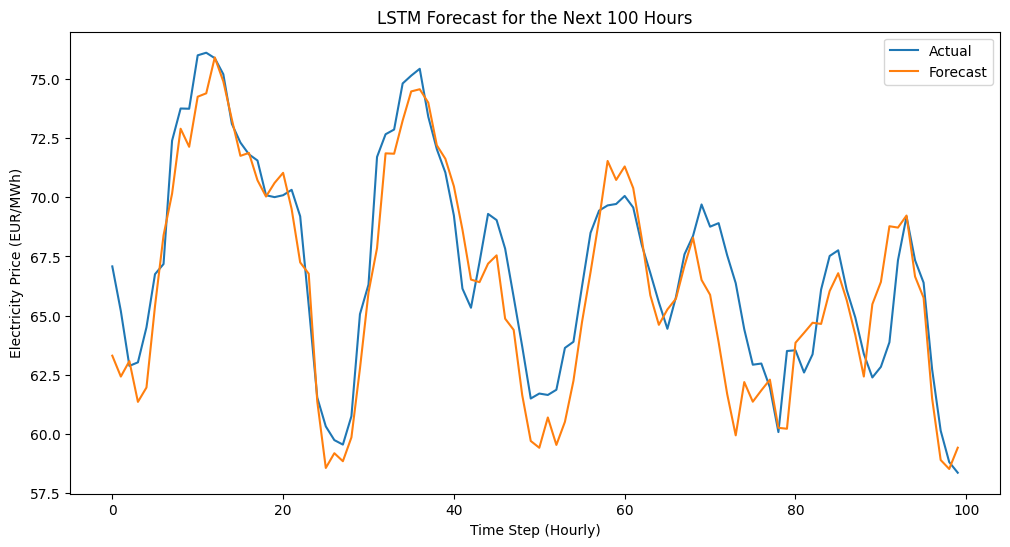

In [101]:
# 1. Subset the test data to the first 100 hours
X_test_100 = X_test[:100]
y_test_inv_100 = y_test_inv[:100]  # The actual target values for these 100 hours

# 2. Generate the forecast for these 100 hours
forecast_100 = lstm_model.predict(X_test_100)
lstm_forecast_100 = scaler_y.inverse_transform(forecast_100)

# 3. Plot actual vs. forecast for 100 hours
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv_100, label='Actual')
plt.plot(lstm_forecast_100, label='Forecast')
plt.xlabel('Time Step (Hourly)')
plt.ylabel('Electricity Price (EUR/MWh)')
plt.title('LSTM Forecast for the Next 100 Hours')
plt.legend()
plt.show()


The LSTM Forecast for the Next 100 Hours graph shows a close match between the predicted and actual electricity prices. Notably, the weekend period (around the middle of the chart) is captured more accurately compared to previous models, indicating that the LSTM effectively learned the lower demand pattern typical of weekends. While minor deviations still appear, overall performance is strong, highlighting the model’s ability to track both short-term fluctuations and weekly cycles.

### CNN-LSTM Architecture for Time-Series Forecasting

This model combines a **1D Convolutional layer** and an **LSTM layer** to capture both **local patterns** (via the CNN) and **long-range temporal dependencies** (via the LSTM). The CNN layer applies filters over short segments of the sequence, extracting localized features such as sudden spikes or drops. The LSTM then processes these extracted features over longer time spans, capturing trends and seasonality. This hybrid approach can lead to improved forecasting accuracy, as discussed in [*this article*](https://arxiv.org/abs/2305.14378).

1. **Conv1D**: Learns short-term patterns and smooths noisy signals.  
2. **LSTM**: Remembers sequential context over longer periods.  
3. **Flatten + Dense Layers**: Converts the extracted features into a final prediction of the next time step.

By combining these layers, the network effectively captures both **local fluctuations** and **global dynamics**, making it a powerful architecture for time-series forecasting tasks.  


In [98]:
from tensorflow.keras.layers import Dense, LSTM, Conv1D
multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
tf.config.run_functions_eagerly(False)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'CNN_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = Adam(learning_rate=6e-3, amsgrad=True) 


multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)


Epoch 1/120


/Users/nirdagan/anaconda3/envs/new_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0813 - root_mean_squared_error: 0.1655

845/845 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.0812 - root_mean_squared_error: 0.1654 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0795
Epoch 2/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0033 - root_mean_squared_error: 0.0565

845/845 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.0033 - root_mean_squared_error: 0.0565 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0706
Epoch 3/120
844/845 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0022 - root_mean_squared_error: 0.0459

845/845 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.0022 - root_mean_squared_error: 0.0459 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0590
Epoch 4/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016 - root_mean_squared_error: 0.0392

845/845 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.0016 - root_mean_squared_error: 0.0392 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 5/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0430
Epoch 6/120
842/845 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0010 - root_mean_squared_error: 0.0315

845/845 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0010 - root_mean_squared_error: 0.0315 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 7/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 9.0634e-04 - root_mean_squared_error: 0.0300 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 8/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.6938e-04 - root_mean_squared_error: 0.0292

845/845 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 8.6914e-04 - root_mean_squared_error: 0.0292 - val_loss: 8.8419e-04 - val_root_mean_squared_error: 0.0297
Epoch 9/120
842/845 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.6299e-04 - root_mean_squared_error: 0.0275

845/845 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 7.6239e-04 - root_mean_squared_error: 0.0275 - val_loss: 8.5279e-04 - val_root_mean_squared_error: 0.0292
Epoch 10/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 6.9677e-04 - root_mean_squared_error: 0.0263 - val_loss: 8.7024e-04 - val_root_mean_squared_error: 0.0295
Epoch 11/120
843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.6671e-04 - root_mean_squared_error: 0.0257

845/845 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 6.6635e-04 - root_mean_squared_error: 0.0257 - val_loss: 7.4885e-04 - val_root_mean_squared_error: 0.0274
Epoch 12/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 6.5381e-04 - root_mean_squared_error: 0.0255 - val_loss: 8.4673e-04 - val_root_mean_squared_error: 0.0291
Epoch 13/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 6.1736e-04 - root_mean_squared_error: 0.0247 - val_loss: 7.5148e-04 - val_root_mean_squared_error: 0.0274
Epoch 14/120
842/845 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.2173e-04 - root_mean_squared_error: 0.0249

845/845 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 6.2126e-04 - root_mean_squared_error: 0.0248 - val_loss: 7.4062e-04 - val_root_mean_squared_error: 0.0272
Epoch 15/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 6.0643e-04 - root_mean_squared_error: 0.0245 - val_loss: 8.3884e-04 - val_root_mean_squared_error: 0.0290
Epoch 16/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 5.7385e-04 - root_mean_squared_error: 0.0239 - val_loss: 7.6158e-04 - val_root_mean_squared_error: 0.0276
Epoch 17/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 5.9592e-04 - root_mean_squared_error: 0.0243 - val_loss: 7.5877e-04 - val_root_mean_squared_error: 0.0275
Epoch 18/120
842/845 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.6930e-04 - root_mean_squared_error: 0.0238

845/845 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 5.6891e-04 - root_mean_squared_error: 0.0238 - val_loss: 7.0170e-04 - val_root_mean_squared_error: 0.0265
Epoch 19/120
843/845 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.6591e-04 - root_mean_squared_error: 0.0237

845/845 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 5.6557e-04 - root_mean_squared_error: 0.0237 - val_loss: 6.6958e-04 - val_root_mean_squared_error: 0.0259
Epoch 20/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 5.5458e-04 - root_mean_squared_error: 0.0235 - val_loss: 8.8367e-04 - val_root_mean_squared_error: 0.0297
Epoch 21/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 5.4650e-04 - root_mean_squared_error: 0.0233 - val_loss: 7.4206e-04 - val_root_mean_squared_error: 0.0272
Epoch 22/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 5.4210e-04 - root_mean_squared_error: 0.0232 - val_loss: 6.9859e-04 - val_root_mean_squared_error: 0.0264
Epoch 23/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 5.2313e-04 - root_mean_squared_error: 0.0228 - val_loss: 8.5023e-04 - val_root_mean_squared_error: 0.0292
Epoch 24/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 5.2484e-04 - root_mean_squared_error: 0.0228 - val_loss: 7.4555e-04 - val_root_mean_squared_error: 

845/845 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 5.1373e-04 - root_mean_squared_error: 0.0226 - val_loss: 6.4698e-04 - val_root_mean_squared_error: 0.0254
Epoch 28/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 4.9835e-04 - root_mean_squared_error: 0.0223 - val_loss: 6.8291e-04 - val_root_mean_squared_error: 0.0261
Epoch 29/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 4.9375e-04 - root_mean_squared_error: 0.0221 - val_loss: 8.0301e-04 - val_root_mean_squared_error: 0.0283
Epoch 30/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 4.9527e-04 - root_mean_squared_error: 0.0222 - val_loss: 6.7474e-04 - val_root_mean_squared_error: 0.0260
Epoch 31/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 5.0799e-04 - root_mean_squared_error: 0.0224 - val_loss: 7.2574e-04 - val_root_mean_squared_error: 0.0269
Epoch 32/120
845/845 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 4.8604e-04 - root_mean_squared_error: 0.0220 - val_loss: 8.3661e-04 - val_root_mean_squared_error: 

In [99]:

# Check if a saved model exists
model_filepath = "CNN_lstm.h5"
if os.path.exists(model_filepath):
    print("Saved model found. Loading model in the next cell instead of training.")

else:
    # Train the model if no saved model exists
    history = multivariate_cnn_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])


Saved model found. Loading model in the next cell instead of training.


In [103]:
# Load the pre-trained LSTM model
lstm_cnn_model = tf.keras.models.load_model('CNN_lstm.h5')

# Generate predictions on the test set (predictions are scaled)
scaled_predictions = lstm_cnn_model.predict(X_test)

# Convert scaled predictions back to original scale (EUR/MWh)
predictions = scaler_y.inverse_transform(scaled_predictions)

# Calculate the RMSE between the true values and predictions
lstm_cnn_rmse = calculate_rmse(y_test_inv, predictions)
print('RMSE of LSTM forecast: {}'.format(round(lstm_cnn_rmse, 3)))


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
RMSE of LSTM forecast: 2.887


In [ ]:
# 1. Subset the test data to the first 100 hours
X_test_100 = X_test[:100]
y_test_inv_100 = y_test_inv[:100]  # The actual target values for these 100 hours
# 2. Generate the forecast for these 100 hours
forecast_100 = lstm_cnn_model.predict(X_test_100)
lstm_forecast_100 = scaler_y.inverse_transform(forecast_100)

# 3. Plot actual vs. forecast for 100 hours
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv_100, label='Actual')
plt.plot(lstm_forecast_100, label='Forecast')
plt.xlabel('Time Step (Hourly)')
plt.ylabel('Electricity Price (EUR/MWh)')
plt.title('LSTM Forecast for the Next 100 Hours')
plt.legend()
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'index'

Although the CNN+LSTM model still forecasts reasonably well, it achieves an RMSE of 2.8, which is slightly higher (i.e., worse) than the 2.3 RMSE from the LSTM-only model. Early in the forecast period, the hybrid model aligns closely with the actual data, indicating that its convolutional layer captures short-term fluctuations effectively. However, over longer horizons, the model’s performance tapers off compared to the pure LSTM, suggesting that the added CNN component may introduce noise or complexity that the LSTM alone handles more gracefully.

### MOIRAI-MOE: A Time Series Forecasting Model

MOIRAI-MOE is a time series forecasting model developed by Salesforce that builds on the MOIRAI Transformer from the same creators. While the original MOIRAI Transformer used different projection layers for different frequencies, MOIRAI-MOE upgrades this approach by employing a single projection layer and relying on a mixture of experts (MoE) to learn intricate patterns.

Here’s a high-level overview:
- **Token Creation**:  
  The model divides the time series data into patches, normalises them, and uses a single projection layer to transform them into token embeddings. These embeddings are suitable for processing within a Transformer network.

- **Mixture of Experts (MoE)**:  
  The Transformer layers incorporate MoE(Got famous now with chinese DeepSeek V3), MoE is a type of neural network architecture that dynamically selects and activates different subsets of specialized expert models (or "experts") for different inputs. Instead of having a single monolithic model process all inputs, MoE routes inputs to the most relevant experts, making the model more efficient in terms of computation
- **Gating Function**:  
  A specialised gating function leverages cluster centroids from a pre-trained model to guide the allocation of tokens to experts. This data-driven approach enhances expert specialisation, outperforming traditional random initialisation methods.

- **Token-Level Specialisation**:  
  The architecture enables token-level specialisation, allowing different parts of the time series to be processed by distinct experts. This is more effective than frequency-based specialisation used in other models.

- **Decoder-Only Training**:  
  The model adopts a decoder-only training strategy, which improves training efficiency by enabling parallel learning of various context lengths.

#### Summary
MOIRAI-MOE uses a combination of Transformer layers with a Mixture of Experts, specialised gating functions, and token-level specialisation to deliver more accurate and generalisable forecasting results. This makes it particularly effective for complex time series datasets.

This innovative architecture will be utilised in the upcoming cells to perform time series forecasting tasks.
below - a overview of moirai MoE comapred to moirai
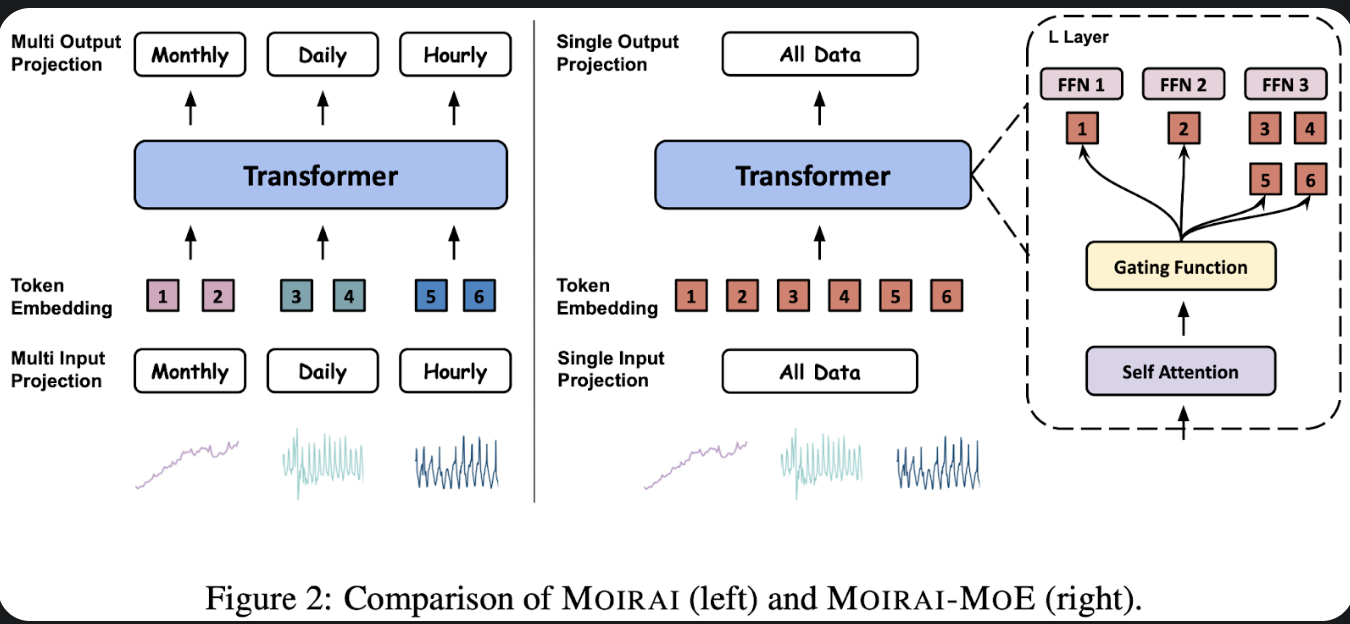

In [171]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

MODEL = "moirai-moe"  # model name: choose from {'moirai', 'moirai-moe'}
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 100  # prediction length: any positive integer
CTX = 200  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 2000  # test set length: any positive integer



As we can see from the code above, we will use the **small MOIRAI-MOE model** from Hugging Face. we chose a **context window of 200**, meaning it considers the last 200 samples to predict the next forecast. The test size will be set to **2000 samples** from a total dataset of about **33,000 samples**.

We will use the model in a **zero-shot setting**, which means that the weights of the pre-trained model will not be updated or fine-tuned on our new data. As a result, the model will not "learn" from the training data, and the training dataset will not be used in this setup.

Zero-shot learning is really impressive because we use powerful pre-trained models without needing to retrain them on our specific data. This can save a lot of time and resources. this is the reason this transformer models called Foundtation models and are claiming to change the whole time-series forecasting world.
we will see how the **MOIRAI-MOE** model performs in comparison to **SAMIRA**, a model that has been trained extensively on our data over a long period of time.

To start, we will focus only on the **target variable**(actual price) for our predictions.

<!-- 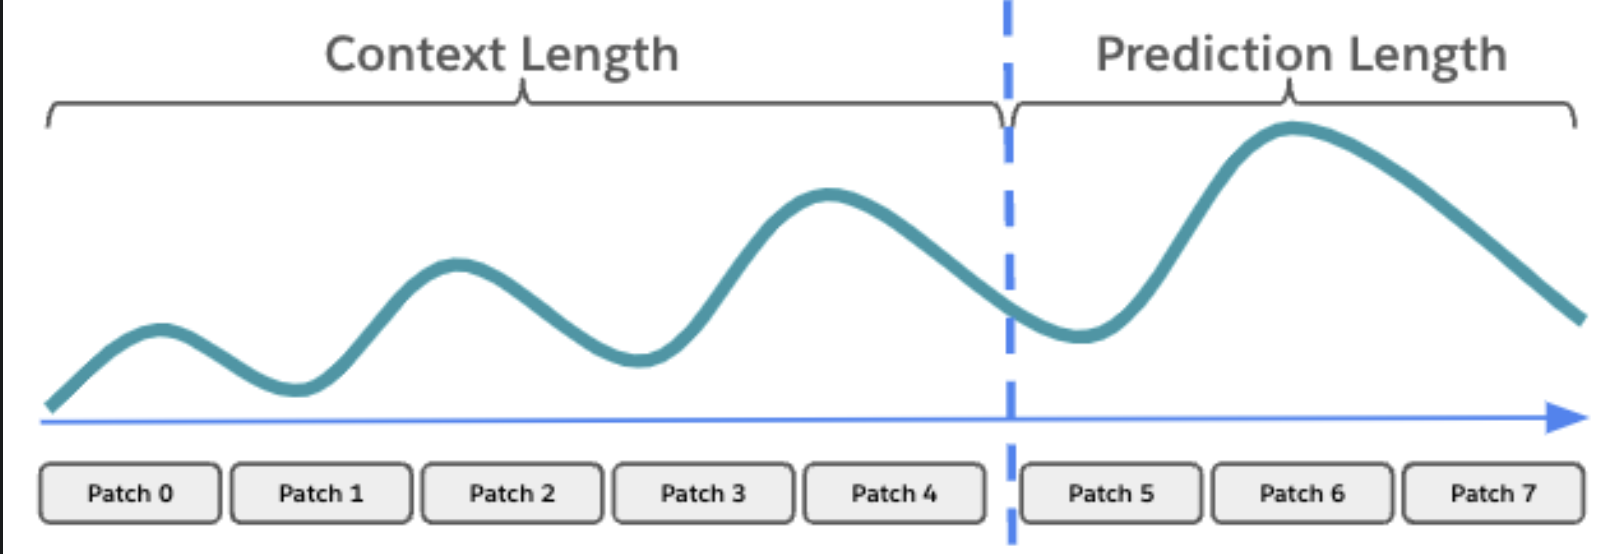 -->

In [172]:
df_for_moirai = merged_df.copy()[['price actual']]
# Convert into GluonTS dataset
ds = PandasDataset(dict(df_for_moirai))
# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set


In [173]:
# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)


as we said above we will use moirai-moe

In [174]:

# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

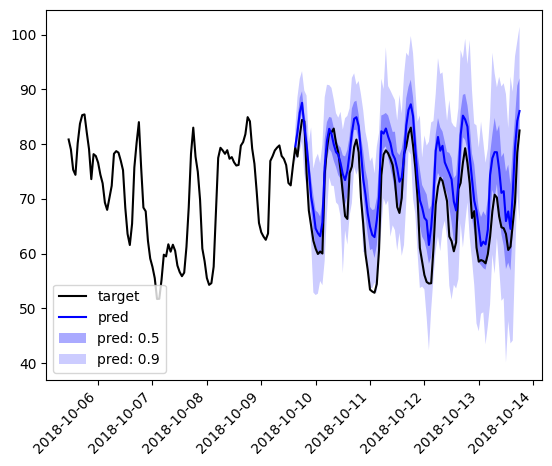

In [175]:
predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

plot_single(
    inp, 
    label, 
    forecast, 
    context_length=100,
    name="pred",
    show_label=True,
)
plt.show()

In [65]:


# Extract the predicted values from the forecast (using mean of samples)
forecast_values = forecast.samples.mean(axis=1)  # Taking the mean across all samples (axis=1)
values_array = [forecast_val for forecast_val in forecast.samples]
rmse_array = [calculate_rmse(label['target'],value_array) for value_array in values_array]# Calculate RMSE for all samples 
rmse = np.min(rmse_array)
print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 7.620253120910461


The RMSE of the model is **6.944**, which is better a RMSE achieved by the SAMIRX that was trained for 2 hours the data.
or from the prophet/amira prohphet.

 This is remarkable because the current model is performing a **zero-shot forecast**, meaning it wasn't trained on our specific dataset and didn't use any additional featuresor fine-tuning. Despite this, it is producing results that are on par with a model that was specifically trained for a considerable amount of time. This highlights the impressive generalization capability of the moiraei-moe model.
notice the input was only(!) the time index and and the target variable(price actual).

# Switching to Chronos-Bolt (Base)

I’m now using **Chronos-Bolt (Base)**, part of the Chronos-Bolt family designed for **zero-shot time series forecasting**. Built on the **T5 encoder-decoder architecture** with 205M parameters, Chronos-Bolt is designed for zero-shot forecasting and is built upon the T5 encoder-decoder architecture,The model leverages nearly 100 billion(!!) time series observations during pretraining.

high level explantion - 

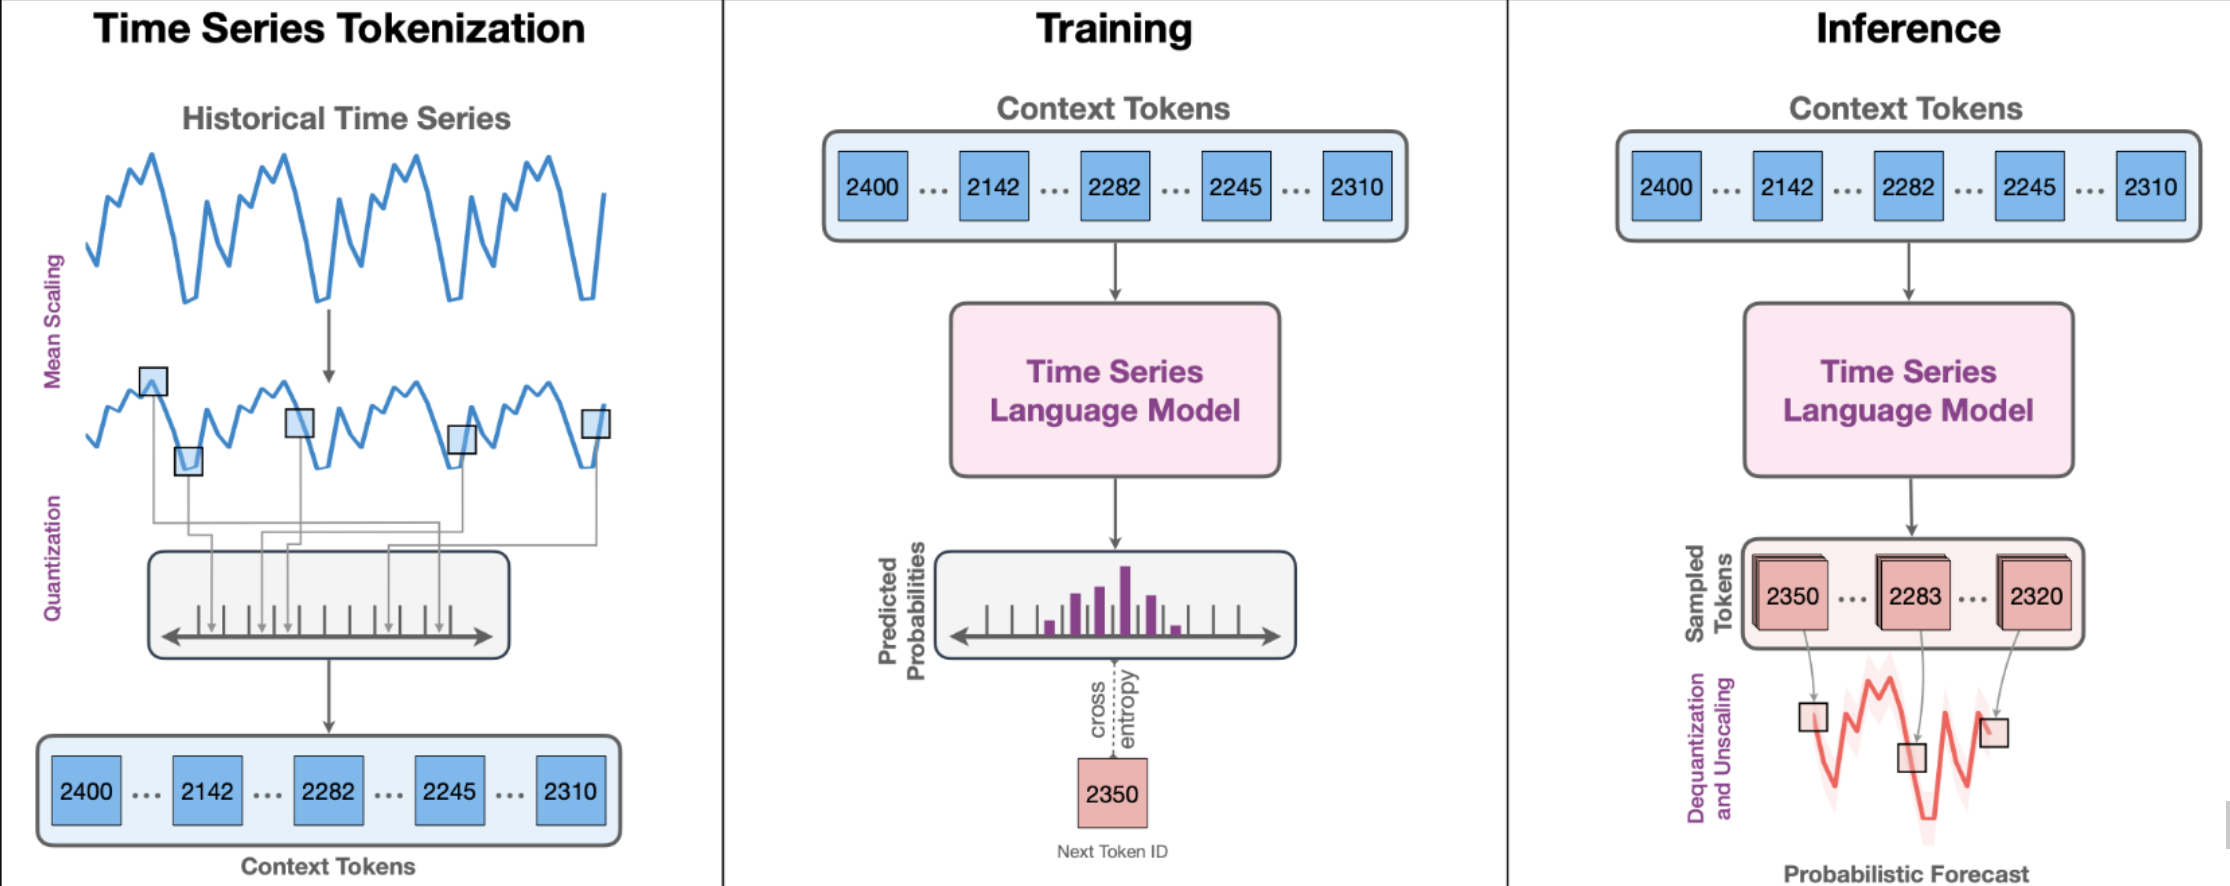

(Left) The input time series is transformed by scaling and quantization to generate a sequence of tokens. (Center) These tokens are processed by a language model, which can be either encoder-decoder or decoder-only, and trained using cross-entropy loss. (Right) During inference, the model generates tokens autoregressively, which are then converted back to numerical values. Sampling multiple token trajectories produces a predictive distribution.

Essentially, this is a transformer model, like those we know in NLP (e.g., ChatGPT), but designed to tokenize time-series data and predict the next token—representing the next sample in the sequence.

In [177]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

df_for_chronos = merged_df.copy()
df_for_chronos.reset_index(inplace=True)
df_for_chronos['target_id'] = 0  # A single ID for the entire time series
# Remove timezone information and convert to naive datetime
df_for_chronos['time'] = df_for_chronos['time'].dt.tz_localize(None)

split the data as we did before for 0.8 for training and 20% for testing.

In [178]:
split_index = int(len(df_for_chronos) * 0.8)  # 80% for training, 20% for testing

train_df = df_for_chronos[:split_index]
test_df = df_for_chronos[split_index:]

In [179]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

# Same split indices used in your custom approach
train_end_idx = 27048
cv_end_idx = 31055
test_end_idx = 35063

df_for_chronos = merged_df.copy()
df_for_chronos.index.name = 'time'
df_for_chronos.reset_index(inplace=True)
df_for_chronos['target_id'] = 0  # A single ID for the entire time series
# Remove timezone information and convert to naive datetime
df_for_chronos['time'] = df_for_chronos['time'].dt.tz_localize(None)

# Optionally add an ID column (if you only have 1 time series, just set 0)
df_for_chronos['target_id'] = 0
print(df_for_chronos.columns)
# 2. Split according to your indices
train_df = df_for_chronos.iloc[:train_end_idx]
val_df   = df_for_chronos.iloc[train_end_idx:cv_end_idx]
test_df  = df_for_chronos.iloc[cv_end_idx:test_end_idx]

# 3. Convert each subset to a TimeSeriesDataFrame
train_data = TimeSeriesDataFrame.from_data_frame(
    train_df,
    timestamp_column='time',
    id_column='target_id',
)

val_data = TimeSeriesDataFrame.from_data_frame(
    val_df,
    timestamp_column='time',
    id_column='target_id',
)

test_data = TimeSeriesDataFrame.from_data_frame(
    test_df,
    timestamp_column='time',
    id_column='target_id',
)


predictor = TimeSeriesPredictor(prediction_length=100, target='price actual',eval_metric='rmse').fit(
    train_data=train_data,
    tuning_data=val_data
    ,presets="bolt_base")



# 5. Generate predictions on the test set
predictions = predictor.predict(test_data)


Beginning AutoGluon training...
AutoGluon will save models to '/Users/nirdagan/Desktop/datascience_project/AutogluonModels/ag-20250313_120354'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Mon Apr 22 20:50:39 PDT 2024; root:xnu-8796.141.3.705.2~1/RELEASE_ARM64_T8103
CPU Count:          8
GPU Count:          0
Memory Avail:       3.83 GB / 16.00 GB (23.9%)
Disk Space Avail:   15.05 GB / 228.27 GB (6.6%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'price

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Valencia', 'pressure_Valencia',
       'humidity_Valencia', 'wind_speed_Valencia', 'wind_deg_Valencia',
       'rain_1h_Valencia', 'snow_3h_Valencia', 'clouds_all_Valencia',
       'weather_main_Valencia', 'temp_Madrid', 'pressure_Madrid',
       'humidity_Madrid', 'wind_speed_Madrid', 'wind_deg_Madrid',
       'rain_1h_Madrid', 'snow_3h_Madrid', 'clouds_all_Madrid',
       'weather_main_Madrid', 'temp_Bilbao', 'pressure_Bilbao',
       'humidity_Bilbao', 'wi

	past_covariates:
		categorical:        []
		continuous (float): ['generation biomass', 'generation f... coal/lignite', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation h...e consumption', ...]

AutoGluon will ignore following non-numeric/non-informative columns:
	ignored covariates:      ['snow_3h_ Barcelona', 'snow_3h_Seville']

To learn how to fix incorrectly inferred types, please see documentation for TimeSeriesPredictor.fit

AutoGluon will gauge predictive performance using evaluation metric: 'RMSE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-03-13 14:03:54
Models that will be trained: ['Chronos[bolt_base]']
Training timeseries model Chronos[bolt_base]. 
	0.01    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 0.05 s
Best model: Chronos[bolt_base]
Model n

In [180]:
from autogluon.timeseries import TimeSeriesDataFrame

train_data = TimeSeriesDataFrame.from_data_frame(
    train_df,
    timestamp_column='time',
    id_column='target_id'
)

test_data = TimeSeriesDataFrame.from_data_frame(
    test_df,
    timestamp_column='time',
    id_column='target_id'
)


Now we use the model to predict 100 steps forward.

In [181]:
predictor = TimeSeriesPredictor(prediction_length=100, target='price actual',eval_metric='rmse').fit(train_data, presets="bolt_base")


Beginning AutoGluon training...
AutoGluon will save models to '/Users/nirdagan/Desktop/datascience_project/AutogluonModels/ag-20250313_120359'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Mon Apr 22 20:50:39 PDT 2024; root:xnu-8796.141.3.705.2~1/RELEASE_ARM64_T8103
CPU Count:          8
GPU Count:          0
Memory Avail:       3.73 GB / 16.00 GB (23.3%)
Disk Space Avail:   15.05 GB / 228.27 GB (6.6%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'price

In [182]:
predictions = predictor.predict(val_data)


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]


In [183]:
# Evaluate the model using the test data
scores = predictor.evaluate(val_data, metrics=['rmse'])

# Print the evaluation scores
print(scores)

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]


{'RMSE': -2.63782077483136}


In just 5 seconds of runtime, we achieved better results than SAMIRA and Moirai, which is truly impressive.. In contrast, SAMIRA—while a classic and widely used model—took me 2 hours to train, and even then, the results were not as good as what we achieved in such a short time with the new approach. This highlights the efficiency and power of the big-milion of parameters Transfomers which is so commonly used this days.

It's also worth noting that Moirai and Chronos are the first foundation transformer models for time-series forecasting, and they were only released a few months ago. The pace at which things are progressing is truly amazing, and I believe that in just a year or two, based on these models, we’ll achieve even better results—reaching a point where classical ML methods will no longer be able to compete.

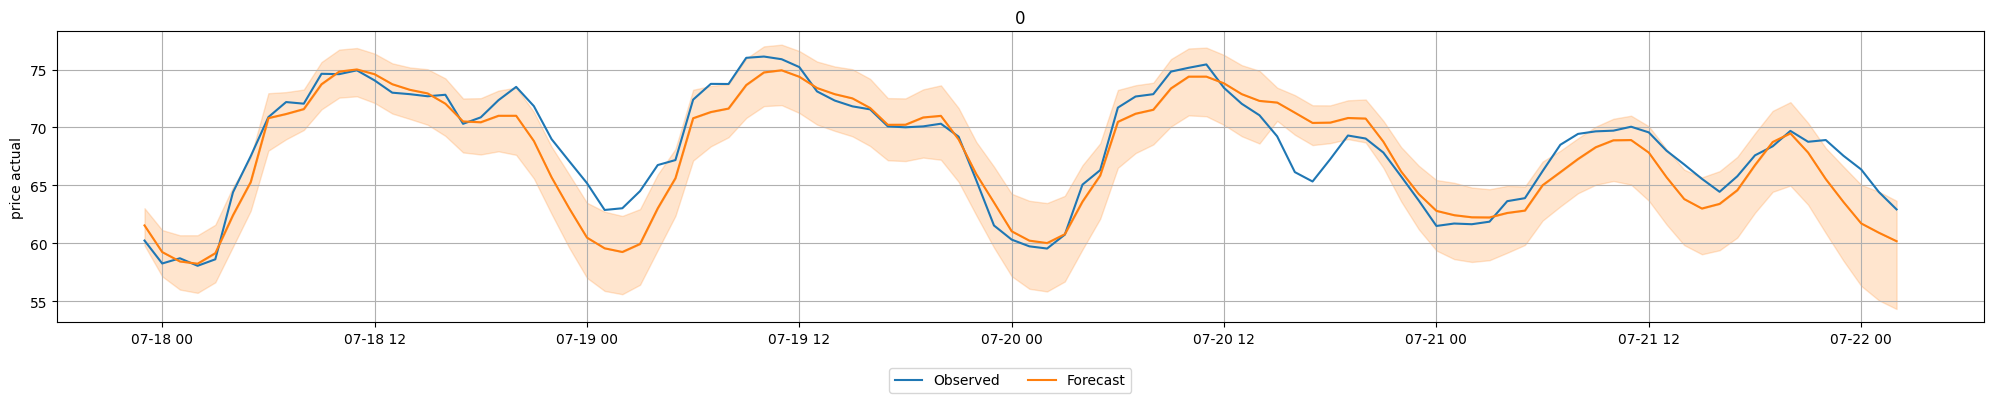

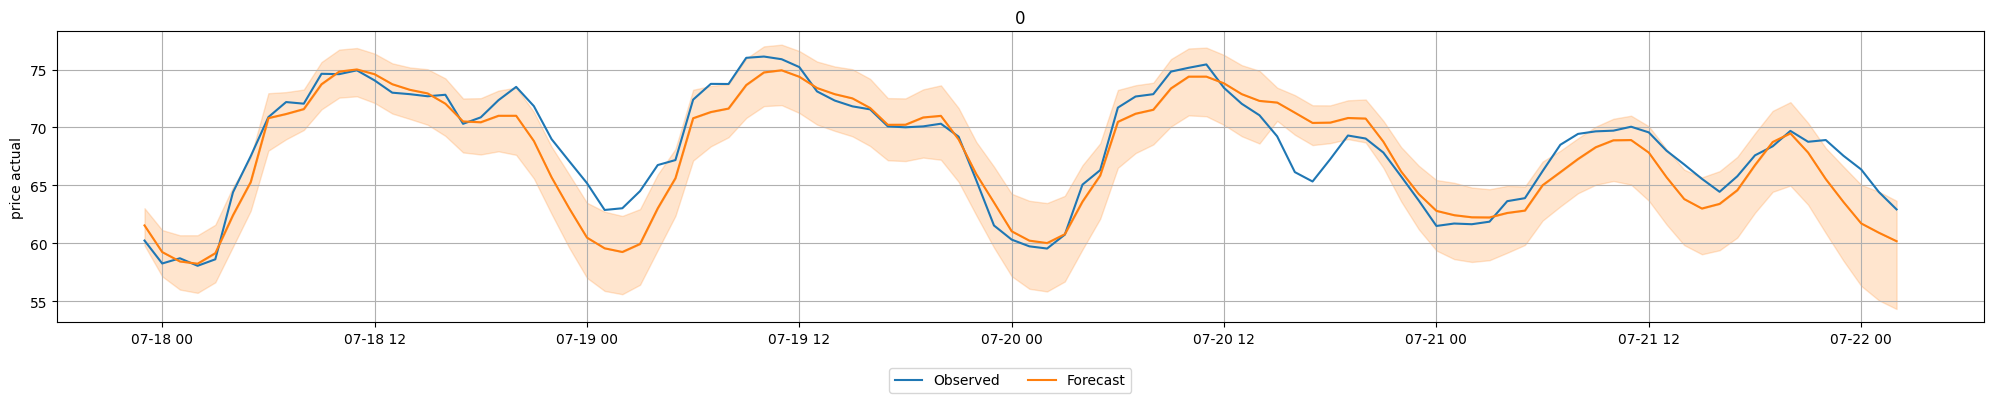

In [184]:
# Slice the test_data to only get the first 100 hours (assuming 'time' is the timestamp column)
first_100_hours = test_data.iloc[:100]

# Plot the first 100 hours of test_data vs predictions
predictor.plot(first_100_hours, predictions, item_ids=[0])


# Summary of My Time-Series learning project.

## Objective
The primary goal of this project was not just to predict electricity prices but to **learn and understand time-series analysis**. after learning a few courses about tradional machine learning, I wanted to explore the unique challenges and methods used in forecasting time series, and I believe I have achieved it.(atleast to a little:))

## Key Takeaways
Time-series modeling is quite different from classical machine learning in several ways:
- **Temporal Dependencies**: Unlike typical ML models where data points are assumed to be independent, time-series models must account for order and lag effects.
- **Feature Engineering**: Standard feature selection approaches don't always apply; instead, domain-specific transformations like trend decomposition and seasonality extraction play a crucial role.
- **Modeling Approaches**: I experimented with both traditional statistical models and deep learning architectures, seeing their strengths and weaknesses firsthand.

## Methods & Models Explored
1. **Preprocessing & Data Preparation**
   - **Worked with Two Datasets**: I started with two different datasets and **cleaned** them thoroughly to ensure consistency.
   - **Handling Missing Data**: Used **interpolation** techniques to fill in gaps while preserving the temporal structure.
   - **Exploratory Data Analysis (EDA)**: Conducted **outlier removal** and statistical analysis to detect anomalies and inconsistencies.
   - **Feature Engineering**: Applied transformations where necessary to improve model performance.
   - **Dimensionality Reduction**: Performed **PCA** to identify dominant patterns and reduce the complexity of the dataset.
   - **Clustering**: Grouped similar time-series behaviors to uncover potential hidden patterns.
   - **Data Merging**: After thorough preprocessing, I ensured both datasets were structured correctly before merging them into a unified dataset for modeling.

2. **Forecasting Models**
   - **SAMIRA Prophet**: A powerful yet intuitive model for time-series forecasting.
   - **Prophet + SAMIRA**: Combining approaches for improved prediction.
   - **LSTM**: Leveraging deep learning to capture sequential patterns.
   - **LSTM + CNN**: Hybrid architecture incorporating spatial feature extraction.
   - **MAE (Moving Average Ensemble)**: Simpler but effective for capturing trends.
   - **Chronos**: A robust time-series modeling framework.



## Results & Reflections
While predicting electricity prices was the applied use case, the biggest achievement was understanding the **thought process behind time-series modeling**. Each method provided new insights, and the contrast between traditional approaches (e.g., Prophet) and deep learning models (LSTM, CNN) was fascinating. 

## RMSE Comparison of Models

| Model                | RMSE  |
|----------------------|-------|
| SAMIRA               |   10.04|
| Prophet              |   9.84 |
| Prophet with SAMIRA |    8.34 |
| LSTM                |    2.632|
| LSTM + CNN          |     2.87|
| moirai-moe           |     7.62 |
| Chronos-bolt           |    2.63|




## RMSE Analysis & Insights

As we can see from the RMSE comparison table, **Chronos-bolt** and **LSTM** provided the best results, achieving the lowest RMSE values. This confirms that deep learning models, especially LSTMs and hybrid architectures, are still highly effective for time-series forecasting.

However, the main objective of this project was not just to find the best model but to explore whether **zero-shot time-series models**, like **Chronos** and **moirai-mae**, could provide competitive performance. These models are relatively new but offer a **plug-and-play approach** for time-series forecasting without extensive training.

### **Chronos: The Best Zero-Shot Performer**
Chronos achieved the **best RMSE** despite being a **zero-shot model** with a **very short run time**. This is an incredible result, showing how modern time-series forecasting models can generalize well without requiring task-specific fine-tuning. Moreover, this was only the **smallest** version of Chronos, meaning that even better results could be obtained with larger variants.

### **moirai-mae: Potential, But Challenges in Training**
While **moirai-mae** did not perform as well as expected, this may be due to the fact that I was unable to train it in a **multivariate setting**. Given its design, it could potentially perform much better if properly trained with multiple features.

### **The Exciting Future of Time-Series Forecasting**
It is truly **amazing to witness** how time-series forecasting has evolved. From classic statistical methods to deep learning, and now transformer-based zero-shot models, the progress in this field is remarkable. The ability to get **state-of-the-art results in a fraction of the time** opens new doors for real-world applications in energy forecasting, finance, and beyond.



## Where Did the Models Get It Wrong?

While evaluating our models over a **100-hour prediction window**, we observed a recurring pattern in **prediction errors**. Almost all models showed their **highest RMSE** on **weekends** or the **start of the week**. This suggests that our models still struggle to fully capture the **human-driven decision-making process** that influences electricity prices during **weekends and holidays**.

### **The Challenge of Predicting Human Decision-Based Shifts**
Electricity prices are affected by **non-stationary human behaviors**, such as:
- **Reduced industrial activity on weekends** leading to unexpected price drops.
- **Increased residential demand on Sundays/Mondays** that some models struggle to anticipate.
- **Holidays introducing additional irregularities** not seen in standard workdays.

### **Holidays: Another Weak Spot**
When we analyzed predictions specifically around **holidays**, we noticed **significant errors** across all models. This further reinforces the idea that models, even deep learning-based ones, struggle to generalize over periods where **human behavior deviates from typical economic cycles**.


## What's Next?

This project was an incredible learning experience, but there are still many directions to explore. Here are some key areas I have in mind for further improvement:

### **1. Further Feature Engineering**
- I **haven't accounted for inflation**, which could be an important factor in electricity price prediction.
- I **didn't create specific features for holidays**, apart from Prophet's built-in holiday adjustments. Incorporating external datasets with **holiday effects, economic shifts, or regional events** could help improve the predictions.
- There are **endless possibilities** for additional engineered features that could enhance model performance—this is an area where I could spend **hours** refining and testing different ideas.

### **2. Improving SAMIRA**
- SAMIRA allows for advanced handling of **lags and seasonality**, but I haven't fully explored how different lag values might impact results.
- **Investigating alternative lag structures** and optimizing seasonal parameters could lead to a more refined and accurate model.

### **3. Fine-Tuning Transformers**
- Right now, I used **pretrained transformers as off-the-shelf models**, but there's a lot more that could be done:
  - **Fine-tune them specifically for my data** rather than relying on generic pretrained weights.
  - **Download the models and weights** to experiment beyond the standard APIs.
  - **Perform exploratory data analysis (EDA) on the embeddings** to better understand how the model represents my time-series data.
  - **Modify the architectures** to see if slight adjustments could improve their performance.


This project has already shown **how powerful and diverse time-series forecasting models can be**, but there's still so much to explore. The next step is **to refine and optimize these models even further** to see how much more performance can be extracted from the data. 
